In [743]:
import pandas as pd
import numpy as np
import csv
import ast
from datetime import datetime
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)

In [995]:
naver_review = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/data/네이버리뷰/naver_review.txt')
kakao_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/카카오리뷰/kakao_review.xlsx')
google_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/구글리뷰/google_reviews.xlsx')
mango_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/망고플레이트/mangoplates_reviews.xlsx')
dinning_review = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/다이닝코드/dinning_review_reshape.xlsx')
dining_like = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/다이닝코드/dinningcode_review_like.xlsx')

# MANGO PLAETE 가격대별 가성비 카테고리 만들기

In [996]:
mango_review.loc[26, 'category'] = '기타 한식'
mango_review.loc[26, 'prices'] = '만원 미만'

In [997]:
for idx, price in enumerate(mango_review.prices):
    price_num = 1.0
    if price == '만원-2만원':
        price_num = 2.0
    elif price == '2만원-3만원':
        price_num = 3.0
    elif price == '3만원-4만원':
        price_num = 4.0
    elif price == '4만원 이상':
        price_num = 5.0
        
    mango_review.loc[idx, 'prices_num'] = price_num

In [998]:
mean_prices = mango_review.groupby('category')['prices_num'].mean()

In [999]:
for idx, price in enumerate(mango_review.prices_num):
    category = mango_review.loc[idx, 'category']
    mango_review.loc[idx, 'relative_price'] = price / mean_prices[category]

In [1000]:
for idx, price in enumerate(mango_review.relative_price):
    # 0.4 미만 - 가성비 훌륭함 (5점)
    # 0.4 ~ 1.0 - 가성비 좋음 (4점)
    # 1.0 - 가성비 그저 그럼, 평균 (3점)
    # 1 ~ 2 - 가성비 나쁨 (2점)
    # 2 ~ - 가성비 극악 (1점)
    if price < 0.4:
        price_grade = 5
    elif price < 1:
        price_grade = 4
    elif price == 1.0:
        price_grade = 3
    elif price < 2:
        price_grade = 2
    else:
        price_grade = 1

    mango_review.loc[idx, 'price_grade'] = price_grade

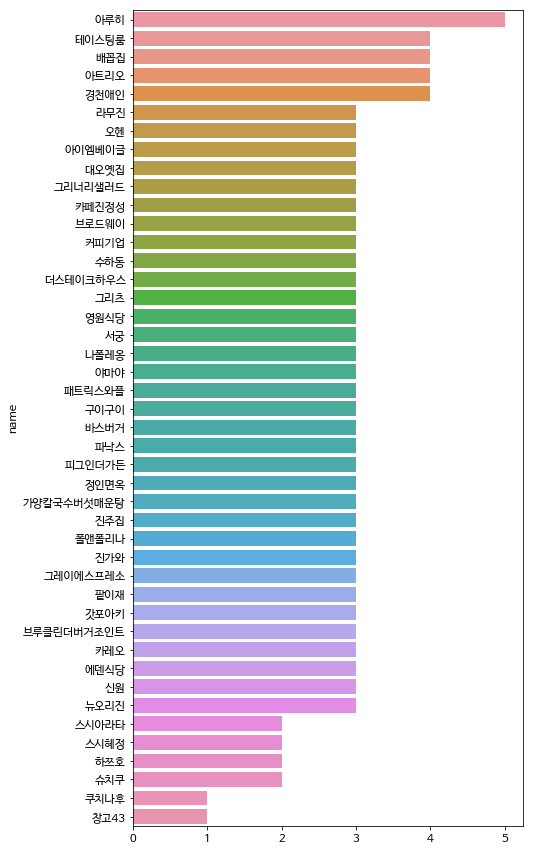

In [1001]:
plt.figure(figsize=(7,15))
price_grade_mango = mango_review.sort_values('price_grade', ascending=False).reset_index(drop=True)
sns.barplot(price_grade_mango.price_grade.values, price_grade_mango.name)

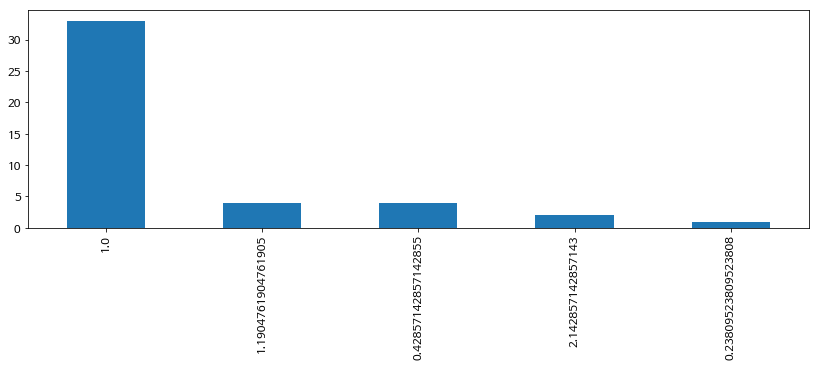

In [1002]:
mango_review.relative_price.value_counts().plot(kind='bar')
# 0.4 미만 - 가성비 훌륭함 (5점)
# 0.4 ~ 1.0 - 가성비 좋음 (4점)
# 1.0 - 가성비 그저 그럼, 평균 (3점)
# 1 ~ 2 - 가성비 나쁨 (2점)
# 2 ~ - 가성비 극악 (1점)

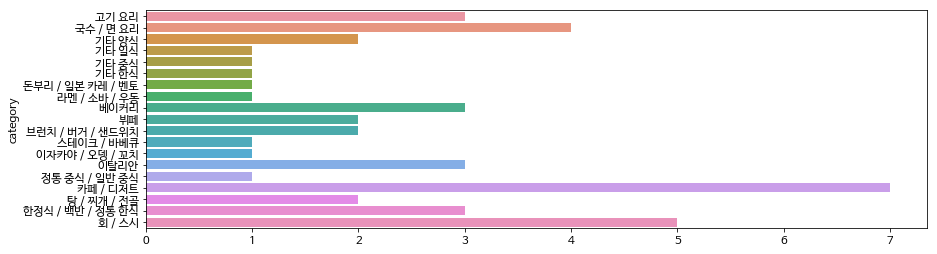

In [1003]:
sns.barplot(mango_review.groupby('category')['prices_num'].count().values, mango_review.groupby('category')['prices_num'].count().index)

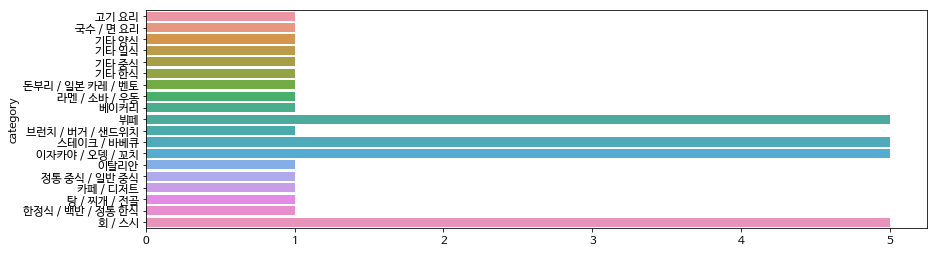

In [1004]:
sns.barplot(mango_review.groupby('category')['prices_num'].median().values, mango_review.groupby('category')['prices_num'].median().index)

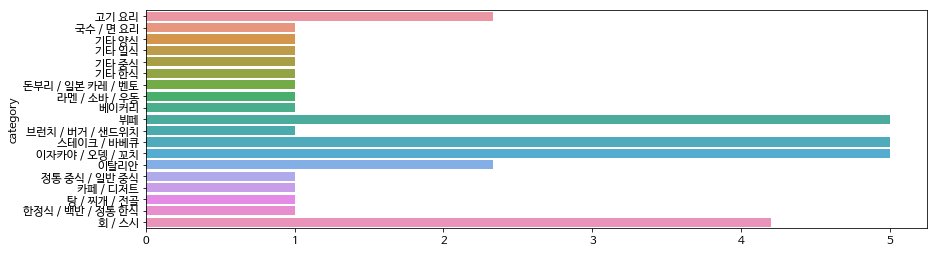

In [1005]:
sns.barplot(mango_review.groupby('category')['prices_num'].mean().values, mango_review.groupby('category')['prices_num'].mean().index)

## NAVER REVIEWS , SCORES , DATES 비교
- 브로드웨이, 아루히, 그리츠 다시 크롤링 후 재저장

In [1006]:
# naver_review_add = pd.read_csv('data/2020-09-03_16_20_link_review.txt', sep='\t').drop('Unnamed: 0', axis=1)
# naver_review_add
# naver_review_add = check_crwal_results(naver_review_add)
# naver_review = check_crwal_results(naver_review)
# naver_review = naver_review[naver_review_add.columns]
# naver_review = naver_review[(naver_review.name!='브로드웨이')&(naver_review.name!='아루히')&(naver_review.name!='그리츠')].reset_index(drop=True)
# naver_review = pd.concat([naver_review_add, naver_review]).sort_values('rank').reset_index(drop=True)
# naver_review = check_crwal_results(naver_review.copy())
# naver_review.to_csv('naver_review.txt', index=False)

In [1007]:
def check_crwal_results(df):
    for i, dates_str in enumerate(df['dates']):
        if dates_str[-1] != '}':
            dates_str = dates_str+'\'}'
        try:
            dates_dict = ast.literal_eval(dates_str)
        except Exception as e:
            print(f'{i}th {e}, {dates_str}')
            dates_str = dates_str.replace('nan', '\'\'')
            dates_dict = ast.literal_eval(dates_str)
        df.loc[i, 'dates_num'] = len(dates_dict)

    for i, scores_str in enumerate(df['scores']):
        try:
            scores_str= scores_str.replace('nan',"\'\'")
        except Exception as e:
            print(f'{i}th {e}, {scores_str}')
        try:
            scores_dict = ast.literal_eval(scores_str)
            df.loc[i, 'scores_num'] = len(scores_dict)
        except Exception as e:
            print(f'{i}th {e}, {scores_str}')

    for i, reviews_str in enumerate(df['reviews']):
        reviews_str = reviews_str.replace('nan', '\'\'')
        try:
            reviews_dict = ast.literal_eval(reviews_str)
        except Exception as e:
            print(f'{i}th {e}, {reviews_str[-50:]}')
            if reviews_str[-1] in str(list(range(10))).replace('[', '').replace(']', '').replace(' ', '').split(','):
                reviews_str = reviews_str[:-3] + '}'
            else:
                reviews_str = reviews_str+ '\'}'
            reviews_dict = ast.literal_eval(reviews_str)
        df.loc[i, 'reviews_num'] = len(reviews_dict)
    return df

# KAKAO reveiw 수정

In [1008]:
# kakao_3add = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/code/data/2020-09-02_22_04_linkkakao_review.csv', sep='\t').drop('Unnamed: 0', axis=1)
# kakao_review = kakao_review.loc[:40]
# kakao_review = pd.concat([kakao_review, kakao_3add])
# kakao_review.to_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/카카오리뷰/kakao_review.xlsx', index=False)

# Mango review, Google review 수정

In [1009]:
mango_review.loc[7, 'allreviews'] = mango_review.allreviews[7] + mango_review.allreviews2[7]

In [1010]:
mango_review.loc[7, 'allreviews'] = mango_review.allreviews[7][:-2]

In [1011]:
google_review.loc[9, 'allreviews'] = google_review.allreviews[9] + google_review.allreviews2[9] + google_review.allreviews3[9]

In [1012]:
google_review.loc[7, 'allreviews'] = google_review.allreviews[7] + google_review.allreviews2[7] + google_review.allreviews3[7]

In [1013]:
google_review.loc[4, 'allreviews'] = google_review.allreviews[4] + google_review.allreviews2[4]

In [1014]:
google_review = google_review.drop(['allreviews2','allreviews3'], axis=1)

In [1015]:
mango_review = mango_review.drop('allreviews2', axis=1)

## google 4번과 9번의 경우 seperator가 달라 나머지 장소와 동일하게 '-'로 변경

In [1016]:
new_str = ''
for idx, x in enumerate(google_review.loc[4, 'allreviews'].split('}')):
    try:
        temp = x.split(':')
        new_str += ''.join([temp[0], ': ', temp[2].strip(), ' -', temp[1].strip(), '-', temp[3].strip(), '}'])
    except Exception as e:
        print(f'{idx}, {e}, {x}')
google_review.loc[4, 'allreviews'] = new_str

968, list index out of range, "


In [1017]:
new_str = ''
for idx, x in enumerate(google_review.loc[7, 'allreviews'].split('}')):
    try:
        temp = x.split(':')
        new_str += ''.join([temp[0], ': ', temp[2].strip(), ' -', temp[1].strip(), '-', temp[3].strip(), '}'])
    except Exception as e:
        print(f'{idx}, {e}, {x}')
google_review.loc[7, 'allreviews'] = new_str

968, list index out of range, "


# google_review 마지막 문자 '"' 제거

In [1018]:
google_review.loc[9, 'allreviews'] = google_review.loc[9, 'allreviews'][:-1]

# mango_review, google_review 전처리

In [1019]:
def preprocessing_allreview(df, seperate = "-"):
    df.dates = ''
    df.scores = ''
    df.reviews = ''
    for idx, review in enumerate(df.allreviews):
        date_dict = {}
        score_dict = {}
        review_dict = {}
        key_ = 0
        try:
            for i, x in enumerate(review.split('}')):
                x = x.replace('{','')
                values = x.split(seperate)
                if len(values)==1:
                    values = x.split(':')
                    if len(values) == 1:
                        continue
                try:
                    if len(values) >= 3:
                        a, b, c = values[:3]
                        review_dict[key_] = c
                    else:
                        a, b = values
                        review_dict[key_] = ''
                    if '전' in b:
                        b = b.replace(' ', '')
                    b = b.replace('-', '.')
                    b = b.rstrip()
                    date_dict[key_] = b
                except Exception as e:
                    print(f'values : {values}')
                    print(f'idx={idx}, i={i} error :{e}, a= "{a.split(" ")[-2]}", b= "{b}", c= "{c}"')
                try:
                    score_dict[key_] = int(a.split(' ')[-2][0])
                except IndexError as e:
                    pass
#                     print(f'values : {values}')
#                     print(f'idx={idx}, i={i} error :{e}')
                key_ += 1

        except AttributeError as e:
            print(f'{idx}, {e}, {review}')

        df.loc[idx, 'dates'] = str(date_dict)
        df.loc[idx, 'scores'] = str(score_dict)
        df.loc[idx, 'reviews'] = str(review_dict)
    return df

## 구글 리뷰 seperator : "-"

In [1020]:
google_review.loc[4, 'allreviews'].split('}')[-30].split('-')

['{940: 별표 4개 ',
 '4주 전',
 '유명한 집이라는데 아직 제가 평양냉면 맛을 몰라서요. 제대로 맛을 느끼려면 1년은 꾸준히 먹어봐야 한다는데.']

## 망고 리뷰 seperator : ":"

In [1021]:
mango_review.loc[6, 'allreviews'].split('}')[-31].split(':')

['{104', '2015-08-15 ', '           아이들과 먹기 딱~~ 게다가.. 아기밥 추가면 추가밥은 무한 무료~~']

In [1022]:
google_review = preprocessing_allreview(google_review, seperate='-')

In [1024]:
google_review = check_crwal_results(google_review.copy())

In [1025]:
mango_review = preprocessing_allreview(mango_review, seperate=':')

In [1026]:
mango_review = check_crwal_results(mango_review.copy())

# 각 사이트 별 리뷰 개수, 점수 구하기 
- 최근 2년 리뷰 개수, 최근 1년 리뷰 개수, 최근 6개월 리뷰 개수, 최근 3개월 리뷰 개수, 최근 1개월 리뷰 개수
- 최근 2년 리뷰 점수, 최근 1년 리뷰 점수, 최근 6개월 리뷰 점수, 최근 3개월 리뷰 점수, 최근 1개월 리뷰 점수

In [1029]:
dinning_review = dinning_review.rename(columns={'score':'scores', 'review':'reviews'})

In [1030]:
dinning_review = check_crwal_results(dinning_review.copy())

23th malformed node or string: <_ast.Name object at 0x135f72ef0>, {0: nan, 1: nan, 2: nan, 3: '2019년 11월 22일', 4: '2019년 8월 22일', 5: '2017년 4월 29일'}


In [1032]:
kakao_review = check_crwal_results(kakao_review.copy()).drop('num_review', axis=1)

In [1034]:
def preprocess_datetime(df:pd.DataFrame, site:str='naver'):
    right_now = datetime.strptime('2020.09.01', '%Y.%m.%d')
    for i, (dates_dict_str, scores_dict_str) in enumerate(zip(df['dates'], df['scores'])):
        try:
            dates_dict = ast.literal_eval(dates_dict_str)
        except ValueError as e:
            dates_dict_str = dates_dict_str.replace('nan', '\'\'')
            print(f'{i}, {e}, in literal_eval')
        except SyntaxError as e:
            dates_dict_str = dates_dict_str + '\'}'
            print(f'{i}, {e}, in literal_eval')
            dates_dict = ast.literal_eval(dates_dict_str)
        try:
            scores_dict = ast.literal_eval(scores_dict_str)
        except Exception as e:
            print(f'{i}, {e}, [scores_dict_str] in literal_eval')
        timedelta_dict = {}
        
        
        min_len = min(len(dates_dict), len(scores_dict))
        if site == 'mango':
            min_len = len(dates_dict)
        for idx in range(min_len):
            date_str = dates_dict[idx]
            if '전' in date_str:
                if '시간' in date_str:
                    timedelta = 0
                elif '일' in date_str:
                    timedelta = int(date_str.split('일')[0])
                elif '달' in date_str:
                    timedelta = 30 * int(date_str.split('달')[0])
                elif '년' in date_str:
                    timedelta = 365 * int(date_str.split('년')[0])
                
            elif '일' in date_str:
                if not '년' in date_str:
                    date_str = '2020년 ' + date_str
                try:
                    timedelta = (right_now - datetime.strptime(date_str, '%Y년 %m월 %d일')).days
                except Exception as e:
                    print(f'{i}, {e}, [date_str] in "%Y년 %m월 %d일" strptime')
            else:
                try:
                    timedelta = (right_now - datetime.strptime(date_str, '%Y.%m.%d')).days
                except Exception as e:
                    print(f'{i}, {e}, [date_str] in "%Y.%m.%d" strptime')
                    if not date_str:
                        continue
            timedelta_dict[idx] = timedelta

        def set_value_wrt_time(df, delta_dict, rowidx, colname, time_bound):
            selected_index = [idx for idx, delta in delta_dict.items() if delta <= time_bound]
            if site != 'mango':
                for col in [colname+'_num', colname+'_score']:
                    if not col in df.columns:
                        df[col] = ''
            try:
                df.loc[rowidx, colname+'_num'] = len(selected_index)
                if site != 'mango':
                    df.loc[rowidx, colname+'_score'] = np.mean([float(scores_dict[x]) for x in selected_index])
            except Exception as e:
                print(scores_dict)
                print(selected_index)
                raise(e)
                print(f'{rowidx}, {e}, {colname} in set_value_wrt_time')

        set_value_wrt_time(df, timedelta_dict, i, f'{site}_2Y', 365*2)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_1Y', 365)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_6M', 30*6)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_3M', 30*3)
        set_value_wrt_time(df, timedelta_dict, i, f'{site}_1M', 30)
        
    return df

In [1035]:
naver_review = preprocess_datetime(naver_review, 'naver')

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1036]:
kakao_review = preprocess_datetime(kakao_review, 'kakao')

4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
4, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
6, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime
7, time data '' does not match format '%Y.%m.%d', [date_str] in "%Y.%m.%d" strptime


In [1037]:
google_review = preprocess_datetime(google_review, 'google')

In [1039]:
mango_review = preprocess_datetime(mango_review.copy(), 'mango')

In [1040]:
dinning_review = preprocess_datetime(dinning_review.copy(), 'dinning')

23, malformed node or string: <_ast.Name object at 0x135f80748>, in literal_eval


/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# 오픈일 지난 날짜 추가

In [1041]:
open_info = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/data/여의도 맛집 list/pilot_lists_with_opendate.csv', encoding='cp949')
open_info = open_info.rename(columns={'dates':'dates_from_open'})

In [1042]:
mango_review = pd.merge(open_info, mango_review, how='outer', on=['rank', 'name']).drop('scores', axis=1)

# 감성 분석 결과 추가

In [1044]:
sentimental = pd.read_csv('/Users/dhkim/PycharmProjects/RealTastySpot/data/감성분석/sentimental_analysis_0903.csv', encoding='cp949')

In [1046]:
sentimental = sentimental.drop('Unnamed: 0', axis=1)

In [1048]:
mango_review.columns

Index(['rank', 'name', 'address', 'open_date', 'start_date', 'dates_from_open',
       'category', 'prices', 'views', 'review_count', 'likes', 'review_score',
       'allreviews', 'prices_num', 'relative_price', 'price_grade', 'dates',
       'reviews', 'dates_num', 'scores_num', 'reviews_num', 'mango_2Y_num',
       'mango_1Y_num', 'mango_6M_num', 'mango_3M_num', 'mango_1M_num'],
      dtype='object')

In [1049]:
sentimental = sentimental.rename(columns={'count':'senti_count', 'score':'senti_score'})

In [1054]:
sentimental.loc[17, 'name'] = '신원'

In [1056]:
mango_review = pd.merge(mango_review, sentimental, how='outer', on='name')

# 각 site raw 데이터 저장

In [1057]:
mango_review.to_csv('../data/망고플레이트/mango_review.txt', index=False)
google_review.to_csv('../data/구글리뷰/google_review.txt', index=False)
kakao_review.to_csv('../data/카카오리뷰/kakao_review.txt', index=False)
dinning_review.to_csv('../data/다이닝코드/dinning_review.txt', index=False)
naver_review.to_csv('../data/네이버리뷰/naver_review.txt', index=False)

# 각 데이터 취합을 위한 column명 변경

In [1062]:
google_review = google_review.drop('review_count', axis=1)

In [1059]:
mango_review = mango_review.drop('review_count', axis=1)

In [1064]:
mango_review = mango_review[['rank', 'name', 'category', 'address', 'open_date', 'start_date', 'dates_from_open',
       'prices', 'prices_num', 'relative_price', 'price_grade', 'senti_count', 'senti_score',
       'views', 'likes', 'review_score', 'allreviews', 'dates', 'reviews',
       'dates_num', 'scores_num', 'reviews_num', 'mango_2Y_num',
       'mango_1Y_num', 'mango_6M_num', 'mango_3M_num', 'mango_1M_num']]

In [1075]:
mango_review = mango_review.rename(columns={old:'mango_'+old for old in mango_review.columns[13:22]})

In [1077]:
google_review = google_review.drop('address', axis=1)

In [1085]:
google_review = google_review.rename(columns={'score':'review_score'})

In [1087]:
google_review = google_review.rename(columns={old:'google_'+old for old in google_review.columns[2:10]})

In [1089]:
naver_review = naver_review.drop(['address', 'link', 'loc_name'], axis=1)

In [1095]:
naver_review = naver_review.rename(columns={old:'naver_'+old for old in naver_review.columns[2:9]})

In [1098]:
naver_review = naver_review.drop('naver_visit_num', axis=1)

In [1101]:
kakao_review = kakao_review.drop(['address', 'link', 'loc_name'], axis=1)

In [1105]:
kakao_review = kakao_review.rename(columns={old:'kakao_'+old for old in kakao_review.columns[2:8]})

In [1111]:
dinning_review = dinning_review.rename(columns={old:'dinning_'+old for old in dinning_review.columns[2:8]})

In [1382]:
mango_review.category.value_counts()

카페 / 디저트            7
회 / 스시              5
국수 / 면 요리           4
고기 요리               3
이탈리안                3
한정식 / 백반 / 정통 한식    3
베이커리                3
뷔페                  2
탕 / 찌개 / 전골         2
기타 양식               2
브런치 / 버거 / 샌드위치     2
스테이크 / 바베큐          1
정통 중식 / 일반 중식       1
이자카야 / 오뎅 / 꼬치      1
라멘 / 소바 / 우동        1
기타 일식               1
기타 한식               1
기타 중식               1
돈부리 / 일본 카레 / 벤토    1
Name: category, dtype: int64

# 각 데이터 merge

In [1117]:
merge1 = pd.merge(mango_review, google_review, on=['name','rank'], how='outer')

In [1118]:
merge2 = pd.merge(merge1, naver_review, on=['name','rank'], how='outer')

In [1119]:
merge3 = pd.merge(merge2, kakao_review, on=['name','rank'], how='outer')

In [1121]:
merge4 = pd.merge(merge3, dinning_review, on=['name','rank'], how='outer')

In [1123]:
merge4.to_csv('../data/총합/final_data.txt', index=False)

In [1130]:
dining_like_reshape = dining_like.groupby('name').count().reset_index()

In [1141]:
dining_like_reshape = dining_like_reshape.rename(columns={'like_date':'dinning_likes'})

In [1143]:
merge5 = pd.merge(merge4, dining_like_reshape, on='name', how='outer')

In [1146]:
merge5.to_csv('../data/총합/final_data.txt', index=False)

In [1147]:
pd.read_csv('../data/총합/final_data.txt').columns

Index(['rank', 'name', 'category', 'address', 'open_date', 'start_date',
       'dates_from_open', 'prices', 'prices_num', 'relative_price',
       'price_grade', 'senti_count', 'senti_score', 'mango_views',
       'mango_likes', 'mango_review_score', 'mango_allreviews', 'mango_dates',
       'mango_reviews', 'mango_dates_num', 'mango_scores_num',
       'mango_reviews_num', 'mango_2Y_num', 'mango_1Y_num', 'mango_6M_num',
       'mango_3M_num', 'mango_1M_num', 'google_review_score',
       'google_allreviews', 'google_dates', 'google_scores', 'google_reviews',
       'google_dates_num', 'google_scores_num', 'google_reviews_num',
       'google_2Y_num', 'google_2Y_score', 'google_1Y_num', 'google_1Y_score',
       'google_6M_num', 'google_6M_score', 'google_3M_num', 'google_3M_score',
       'google_1M_num', 'google_1M_score', 'naver_reviews', 'naver_scores',
       'naver_dates', 'naver_dates_num', 'naver_scores_num',
       'naver_reviews_num', 'naver_2Y_num', 'naver_2Y_score', 'naver

In [1157]:
merge_final = pd.merge(pd.read_csv('/Users/dhkim/Downloads/final_data_0903.txt').drop('Unnamed: 0', axis=1), dining_like_reshape, on='name', how='outer')

In [1160]:
merge_final = merge_final.drop(33).reset_index(drop=True)

In [1166]:
merge_final.to_csv('../data/총합/final_data_0903.txt', index=False)

In [1167]:
merge_final = merge_final.drop(['category', 'address', 'open_date', 'start_date', 'prices', 'prices_num', 'relative_price'], axis=1)

In [1168]:
merge_final.columns 

Index(['rank', 'name', 'dates_from_open', 'price_grade', 'senti_count',
       'senti_score', 'mango_views', 'mango_likes', 'mango_review_score',
       'mango_allreviews', 'mango_dates', 'mango_reviews', 'mango_dates_num',
       'mango_scores_num', 'mango_reviews_num', 'mango_2Y_num', 'mango_1Y_num',
       'mango_6M_num', 'mango_3M_num', 'mango_1M_num', 'google_review_score',
       'google_allreviews', 'google_dates', 'google_scores', 'google_reviews',
       'google_dates_num', 'google_scores_num', 'google_reviews_num',
       'google_2Y_num', 'google_2Y_score', 'google_1Y_num', 'google_1Y_score',
       'google_6M_num', 'google_6M_score', 'google_3M_num', 'google_3M_score',
       'google_1M_num', 'google_1M_score', 'naver_reviews', 'naver_scores',
       'naver_dates', 'naver_dates_num', 'naver_scores_num',
       'naver_reviews_num', 'naver_2Y_num', 'naver_2Y_score', 'naver_1Y_num',
       'naver_1Y_score', 'naver_6M_num', 'naver_6M_score', 'naver_3M_num',
       'naver_3M_scor

In [1169]:
merge_final2 = merge_final[['rank', 'name', 'dates_from_open', 'price_grade',
       'senti_score', 'mango_likes', 'dinning_likes', 'mango_review_score',
       'mango_1Y_num', 'mango_6M_num', 'google_1Y_num', 'google_1Y_score',
       'google_6M_num', 'google_6M_score', 'naver_1Y_num', 'naver_1Y_score',
       'naver_6M_num', 'naver_6M_score', 'kakao_1Y_num', 'kakao_1Y_score',
       'kakao_6M_num', 'kakao_6M_score', 'dinning_1Y_num', 'dinning_1Y_score',
       'dinning_6M_num', 'dinning_6M_score']]

In [1175]:
merge_final2['dinning_likes'] = merge_final2['dinning_likes'].fillna(0)

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1177]:
merge_final2.loc[:, 'mango_dinning_likes'] = merge_final2.apply(lambda row:row['mango_likes'] + row['dinning_likes'], axis=1)

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [1229]:
_6M_score = [col for col in merge_final2.columns if '_6M_score' in col] + ['mango_review_score']
_1Y_score = [col for col in merge_final2.columns if '_1Y_score' in col] + ['mango_review_score']  

In [1230]:
_6M_num = [col for col in merge_final2.columns if '_6M_num' in col]
_1Y_num = [col for col in merge_final2.columns if '_1Y_num' in col]   

In [1221]:
merge_final2['mango_review_score'] = merge_final2['mango_review_score'].map(lambda x:float(x))

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1226]:
merge_final2.loc[43, 'mango_review_score'] = np.nan

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [1286]:
(merge_final2['google_1Y_num'] / merge_final2['google_6M_num']).dropna().drop(19).mean()

4.267372415227962

In [1288]:
merge_final2.loc[33, 'google_6M_score'] = 4.2
merge_final2.loc[33, 'google_1Y_score'] = 4.2
merge_final2.loc[33, 'google_1Y_num'] = 340
merge_final2.loc[33, 'google_6M_num'] = 80 # 구글 리뷰 1년/6개월 평균 개수 비율이 4.27이었음 이를 반영

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [1289]:
merge_final2['6M_score'] = ''
for idx, row in merge_final2[_6M_score].iterrows():
    if idx==43:
        print(row.dropna())
    try:
        merge_final2.loc[idx, '6M_score'] = row.dropna().mean()
    except Exception as e:
        print(e, row)

google_6M_score    4.411765
naver_6M_score     4.765517
kakao_6M_score     3.000000
Name: 43, dtype: float64


/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1290]:
merge_final2['1Y_score'] = ''
for idx, row in merge_final2[_1Y_score].iterrows():
    merge_final2.loc[idx, '1Y_score'] = row.dropna().mean()

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1291]:
merge_final2['6M_num'] = ''
for idx, row in merge_final2[_6M_num].iterrows():
    merge_final2.loc[idx, '6M_num'] = row.dropna().sum()

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1292]:
merge_final2['1Y_num'] = ''
for idx, row in merge_final2[_1Y_num].iterrows():
    merge_final2.loc[idx, '1Y_num'] = row.dropna().sum()

/Users/dhkim/.pyenv/versions/xai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1293]:
merge_final2.columns

Index(['rank', 'name', 'dates_from_open', 'price_grade', 'senti_score',
       'mango_likes', 'dinning_likes', 'mango_review_score', 'mango_1Y_num',
       'mango_6M_num', 'google_1Y_num', 'google_1Y_score', 'google_6M_num',
       'google_6M_score', 'naver_1Y_num', 'naver_1Y_score', 'naver_6M_num',
       'naver_6M_score', 'kakao_1Y_num', 'kakao_1Y_score', 'kakao_6M_num',
       'kakao_6M_score', 'dinning_1Y_num', 'dinning_1Y_score',
       'dinning_6M_num', 'dinning_6M_score', 'mango_dinning_likes', '6M_score',
       '1Y_score', '6M_num', '1Y_num'],
      dtype='object')

In [1294]:
merge_final3 = merge_final2[['rank', 'name', 'dates_from_open', 'price_grade', 'senti_score',
       'mango_dinning_likes', '6M_score',
       '1Y_score', '6M_num', '1Y_num']]

In [1301]:
merge_final4 = merge_final3.drop(['1Y_score', '1Y_num'], axis=1)

In [1305]:
merge_final4.to_csv('../data/feature/real_tasty_spot_feature_data.txt', index=False)

In [1306]:
merge_final4

,rank,name,dates_from_open,price_grade,senti_score,mango_dinning_likes,6M_score,6M_num
0,1,스시아라타,183,2.0,0.596388,3443.0,4.5439,33
1,2,오헨,983,3.0,0.605211,3525.0,4.29167,22
2,3,하쯔호,2414,2.0,0.606863,1724.0,4.54118,35
3,4,피그인더가든,284,3.0,0.554179,2464.0,3.99647,223
4,5,정인면옥,2337,3.0,0.570807,2968.0,4.1435,310
5,6,아트리오,1356,4.0,0.595162,595.0,3.71657,95
6,7,가양칼국수버섯매운탕,13286,3.0,0.539373,3816.0,3.89761,234
7,8,진주집,3008,3.0,0.589469,5356.0,4.058,660
8,9,폴앤폴리나,3206,3.0,0.628352,2313.0,4.56848,64
9,10,바스버거,1418,3.0,0.651866,1939.0,3.97485,222


Text(0.5, 0.91, '6M_score 기준 정렬')

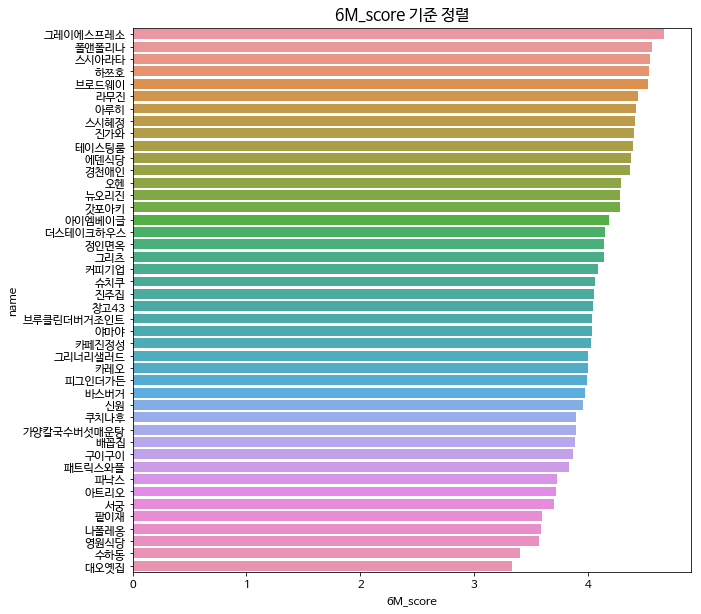

In [1296]:
temp_ = merge_final3.sort_values('6M_score', ascending=False)
fig = plt.figure(figsize=(10,10))
ax = sns.barplot(temp_['6M_score'], temp_['name'])
fig.suptitle('6M_score 기준 정렬', y=0.91, fontsize=16)

Text(0.5, 0.91, '6M_num 기준 정렬')

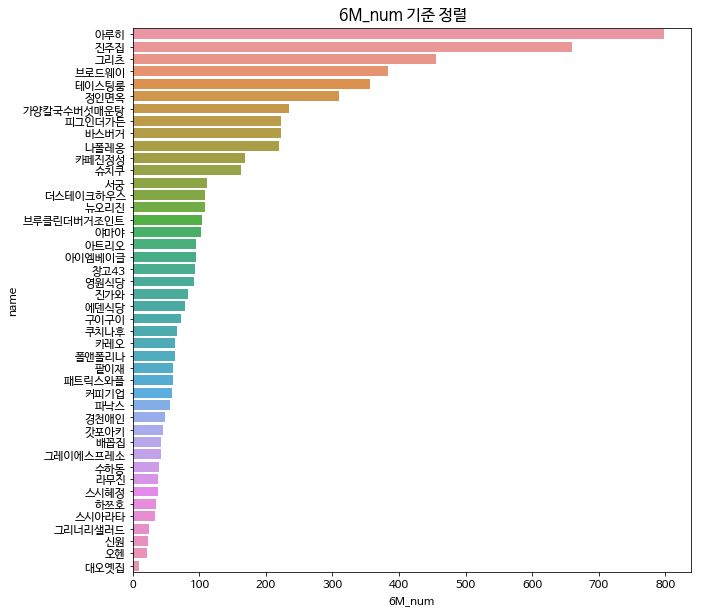

In [1302]:
temp_ = merge_final3.sort_values('6M_num', ascending=False)
fig = plt.figure(figsize=(10,10))
ax = sns.barplot(temp_['6M_num'], temp_['name'])
fig.suptitle('6M_num 기준 정렬', y=0.91, fontsize=16)

# normalization and setting weights for TastyScore

In [1309]:
feature_data = pd.read_csv('/Users/dhkim/Downloads/real_tasty_spot_feature_data_nor_0904.txt').drop('Unnamed: 0', axis=1)

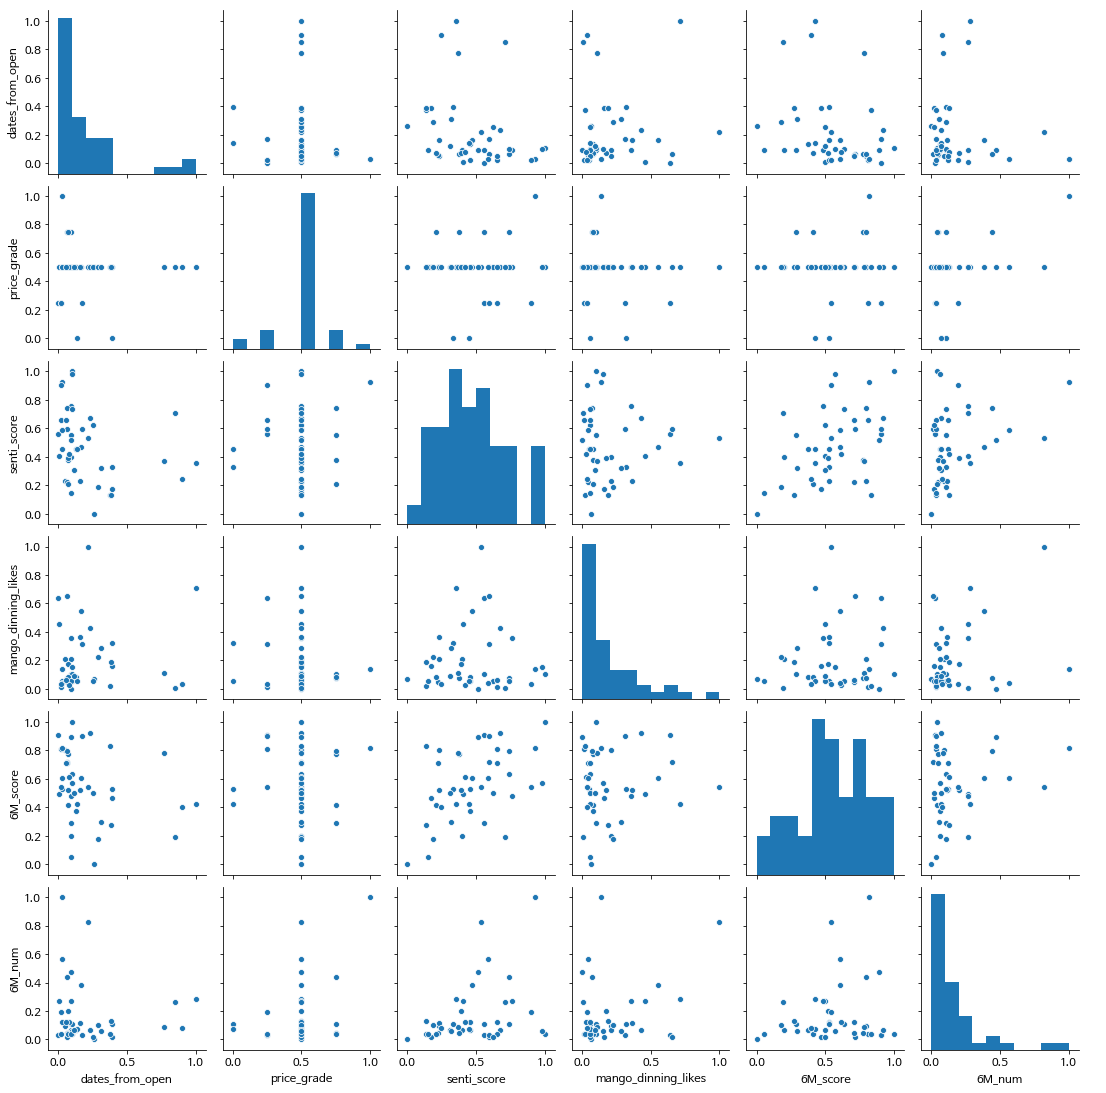

In [1310]:
sns.pairplot(feature_data[feature_data.columns[2:]])

### dates_from_open:price_grade:[senti_score:mango_dinning_likes:6M_score:6M_num] = 1:1:1

In [1312]:
feature_data['tastyscore_d1_p1_r1'] = ''

In [1316]:
r = ['senti_score', 'mango_dinning_likes', '6M_score', '6M_num']

In [1320]:
feature_data['tastyscore_d1_p1_r1'] = feature_data['dates_from_open'] + feature_data['price_grade'] + feature_data[r].sum(axis=1)/4

### dates_from_open:price_grade:[senti_score:mango_dinning_likes:6M_score:6M_num] = 2:1:1

In [1313]:
feature_data['tastyscore_d2_p1_r1'] = ''

In [1321]:
feature_data['tastyscore_d2_p1_r1'] = 2*feature_data['dates_from_open'] + feature_data['price_grade'] + feature_data[r].sum(axis=1)/4

### dates_from_open:price_grade:[senti_score:mango_dinning_likes:6M_score:6M_num] = 1:2:1

In [1314]:
feature_data['tastyscore_d1_p2_r1'] = ''

In [1322]:
feature_data['tastyscore_d1_p2_r1'] = feature_data['dates_from_open'] + feature_data['price_grade']*2 + feature_data[r].sum(axis=1)/4

### dates_from_open:price_grade:[senti_score:mango_dinning_likes:6M_score:6M_num] = 1:1:2

In [1315]:
feature_data['tastyscore_d1_p1_r2'] = ''

In [1323]:
feature_data['tastyscore_d1_p1_r2'] = feature_data['dates_from_open'] + feature_data['price_grade'] + feature_data[r].sum(axis=1)/2

# TastyScore nomralization

In [1332]:
from sklearn.preprocessing import MinMaxScaler
def scaling_column(df, col_name):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df[col_name].to_numpy().reshape((-1, 1))) 
    df[col_name + '_scaled'] = scaled_values
    return df

In [1353]:
def plot_sorted_bargraph(df, colname):
    fig = plt.figure(figsize=(10,10))
    temp_df = df.sort_values(colname, ascending=False)
    fig.suptitle(colname, y=0.92, size=19)
    sns.barplot(temp_df[colname], temp_df['name'])
    plt.savefig(colname+'.png', dpi=300)

In [1333]:
feature_data = scaling_column(feature_data, 'tastyscore_d1_p1_r1')

In [1364]:
feature_data['d1_p1_r1_rank'] = feature_data['tastyscore_d1_p1_r1'].rank(ascending=False).astype(int)
feature_data['d2_p1_r1_rank'] = feature_data['tastyscore_d2_p1_r1'].rank(ascending=False).astype(int)
feature_data['d1_p2_r1_rank'] = feature_data['tastyscore_d1_p2_r1'].rank(ascending=False).astype(int)
feature_data['d1_p1_r2_rank'] = feature_data['tastyscore_d1_p1_r2'].rank(ascending=False).astype(int)

In [1367]:
feature_data.to_csv('../data/feature/feature_data_with_tastyscore.txt', index=False)

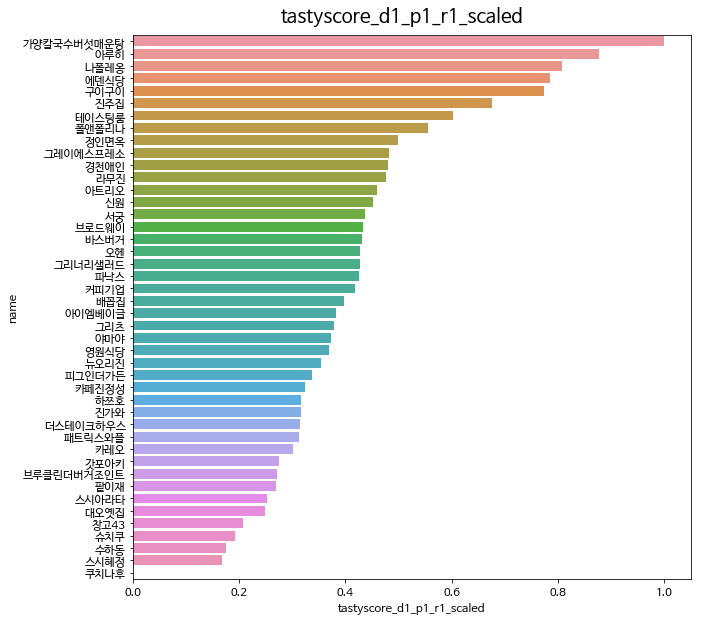

In [1354]:
plot_sorted_bargraph(feature_data, 'tastyscore_d1_p1_r1_scaled')

In [1335]:
feature_data = scaling_column(feature_data, 'tastyscore_d2_p1_r1')

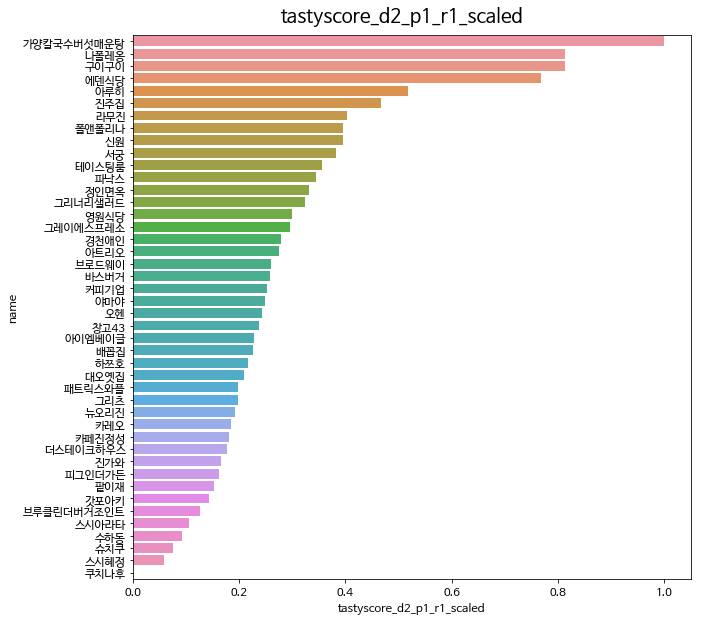

In [1355]:
plot_sorted_bargraph(feature_data, 'tastyscore_d2_p1_r1_scaled')

In [1336]:
feature_data = scaling_column(feature_data, 'tastyscore_d1_p2_r1')

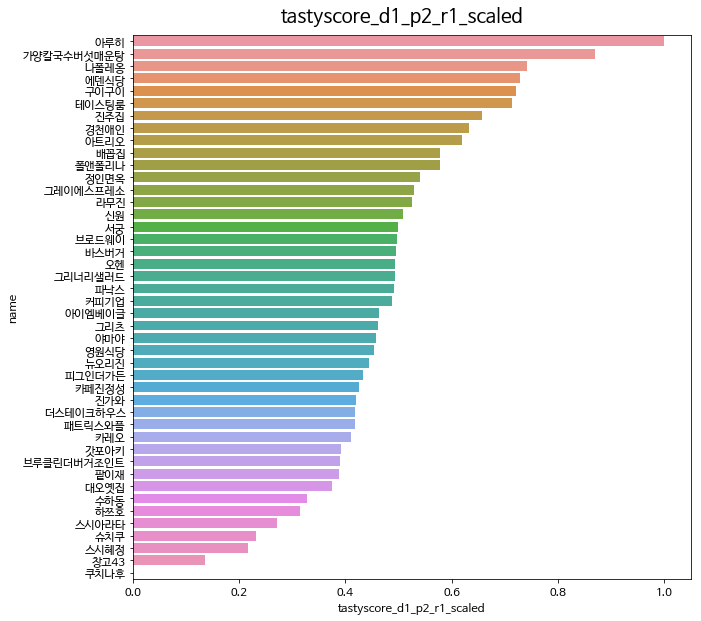

In [1356]:
plot_sorted_bargraph(feature_data, 'tastyscore_d1_p2_r1_scaled')

In [1337]:
feature_data = scaling_column(feature_data, 'tastyscore_d1_p1_r2')

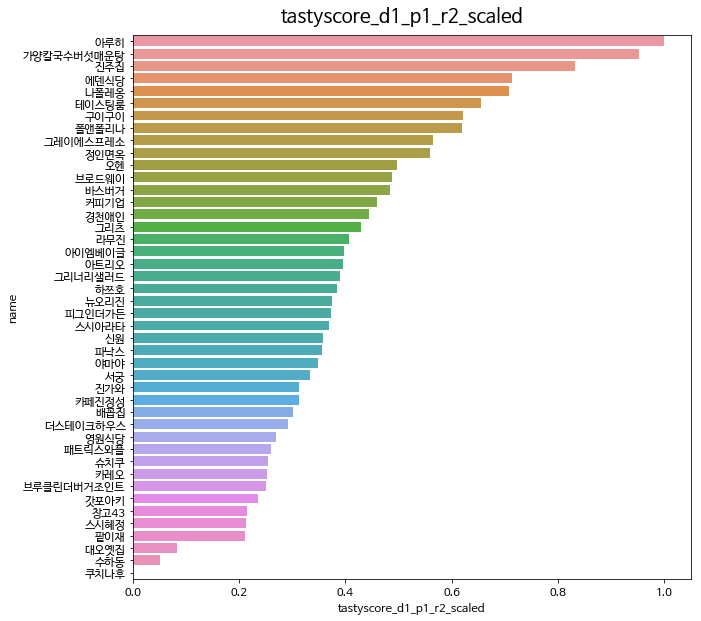

In [1357]:
plot_sorted_bargraph(feature_data, 'tastyscore_d1_p1_r2_scaled')

### senti_score:6M_num:6M_score:mango_dinning_likes = 4:3:2:1

In [1368]:
feature_data['review_score1'] = feature_data['senti_score']*4 + feature_data['6M_num']*3 + feature_data['6M_score']*2 +feature_data['mango_dinning_likes']

In [1370]:
feature_data = scaling_column(feature_data, 'review_score1')

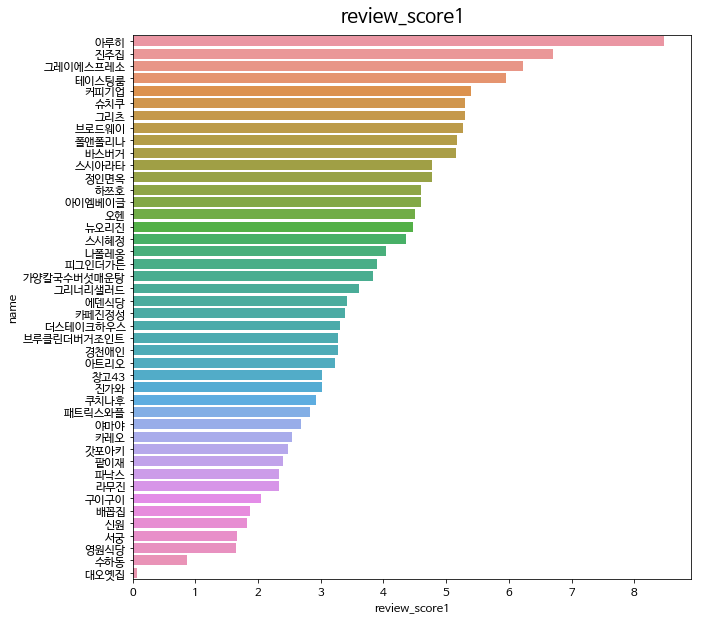

In [1372]:
plot_sorted_bargraph(feature_data, 'review_score1')

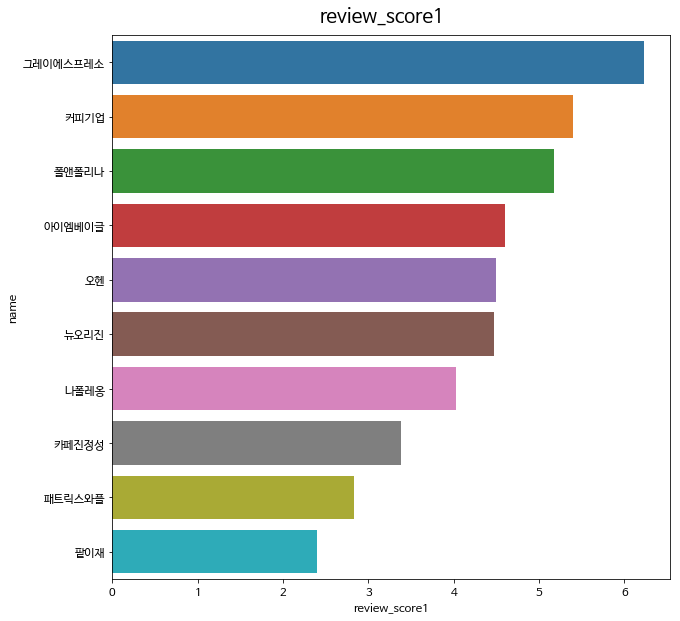

In [1480]:
plot_sorted_bargraph(cafe_data, 'review_score1')

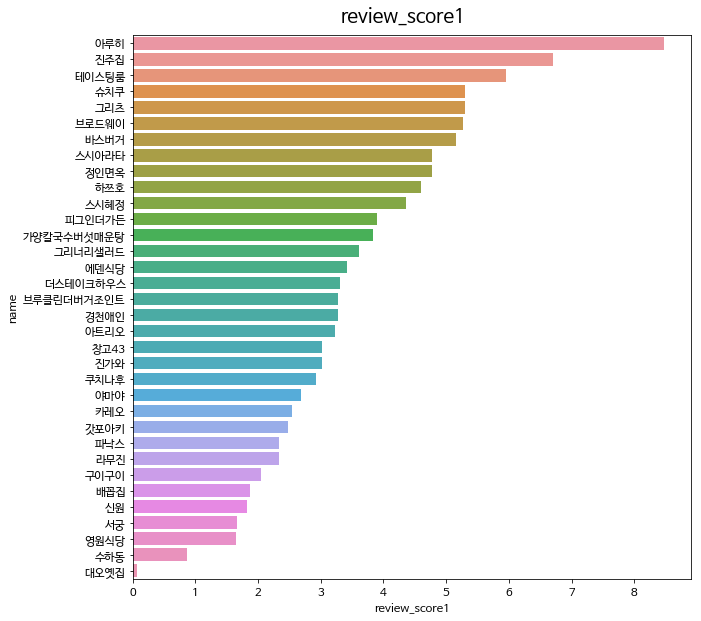

In [1481]:
plot_sorted_bargraph(non_cafe_data, 'review_score1')

### 6M_num:senti_score:6M_score:mango_dinning_likes = 4:3:2:1

In [1369]:
feature_data['review_score2'] = feature_data['senti_score']*3 + feature_data['6M_num']*4 + feature_data['6M_score']*2 +feature_data['mango_dinning_likes']

In [1371]:
feature_data = scaling_column(feature_data, 'review_score2')

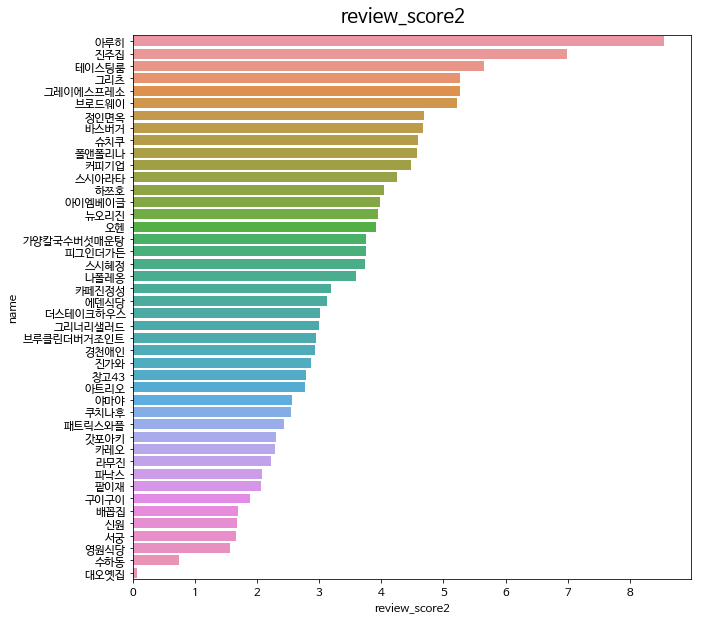

In [1373]:
plot_sorted_bargraph(feature_data, 'review_score2')

In [1378]:
feature_data.to_csv('../data/feature/feature_data_review_add.txt', index=False)

In [1377]:
feature_data['review_score2_rank'] = feature_data['review_score2'].rank(ascending=False).astype(int)
feature_data['review_score1_rank'] = feature_data['review_score1'].rank(ascending=False).astype(int)

# 가성비 정보 수정에 따른 새로운 맛집 목록 리스트화
### 1. 카테고리 분류 단순화 (8가지로 만들기, 여의도 파일럿에선 6가지만 존재)
### 2. 분류 후 각 카테고리 별 가성비 점수 구하기
### 3. 가성비 점수에 따른 리스트화 (전체)
### 4. 카페 리스트 따로 / 식당 리스트 따로

----
## 1. 카테고리 분류 단순화 (8가지로 만들기, 여의도 파일럿에선 6가지만 존재)

## 카테고리 데이터 전처리

In [1383]:
category = pd.read_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/카테고리 분류/category.xlsx')

In [1400]:
category.loc[5, 'category'] = '한정식 / 백반 / 정통 한식'
category = category.rename(columns={'Category':'category'})
mango_review['category'].unique()
set(category['category']) - set(mango_review['category'].unique())
category.loc[category['category']=='기타 한식 ', 'category'] = '기타 한식'
category.loc[category['category']=='뷔페 ', 'category'] = '뷔페'

In [1409]:
category = pd.merge(mango_review[['name', 'category']], category, how='outer', on='category')

In [1411]:
category.to_excel('/Users/dhkim/PycharmProjects/RealTastySpot/data/카테고리 분류/category.xlsx', index=False)

In [1416]:
category.columns

Index(['name', 'category', 'New_category'], dtype='object')

In [1421]:
feature_data = pd.merge(category[['name','New_category']], feature_data, how='outer', on =['name'])

----
## 2. 분류 후 각 카테고리 별 가성비 점수 구하기

In [1423]:
feature_data['cost-effective'] = ''

In [1430]:
feature_data.columns

Index(['name', 'New_category', 'rank', 'dates_from_open', 'price_grade',
       'senti_score', 'mango_dinning_likes', '6M_score', '6M_num',
       'tastyscore_d1_p1_r1', 'tastyscore_d2_p1_r1', 'tastyscore_d1_p2_r1',
       'tastyscore_d1_p1_r2', 'tastyscore_d1_p1_r1_scaled',
       'tastyscore_d2_p1_r1_scaled', 'tastyscore_d1_p2_r1_scaled',
       'tastyscore_d1_p1_r2_scaled', 'd1_p1_r1_rank', 'd2_p1_r1_rank',
       'd1_p2_r1_rank', 'd1_p1_r2_rank', 'review_score1', 'review_score2',
       'review_score1_scaled', 'review_score2_scaled', 'review_score2_rank',
       'review_score1_rank', 'cost-effective'],
      dtype='object')

In [ ]:
def simple_divide(each_group):
    new_group = each_group.reset_index()
    new_group['review_score1']
    simple_divide[]

In [1439]:
feature_data = pd.merge(mango_review[['name', 'prices_num']], feature_data, how='outer', on='name')

## each_group reveiw score normalization

In [1443]:
each_group_min = feature_data.groupby('New_category').min()['review_score1']

In [1444]:
each_group_max = feature_data.groupby('New_category').max()['review_score1']

In [1447]:
for i, row in feature_data.iterrows():
    each_min = each_group_min[row['New_category']]
    each_max = each_group_max[row['New_category']]
    feature_data.loc[i, 'review_score1_scaled_wrt_cat'] = (feature_data.loc[i, 'review_score1'] - each_min)/(each_max - each_min)

## each_group cost_effectiveness (simple)

In [1453]:
feature_data['cost_effectiveness'] = ''
feature_data.loc[:, 'cost_effectiveness'] = feature_data.apply(lambda row:row['review_score1_scaled_wrt_cat']/row['prices_num'], axis=1)

## each_group cost_effectiveness (평균 가격대 반영)

In [ ]:
each_group_min = feature_data.groupby('New_category').min()['prices_num']
each_group_max = feature_data.groupby('New_category').max()['review_score1']

---
## 3. 가성비 점수에 따른 리스트화 (전체)

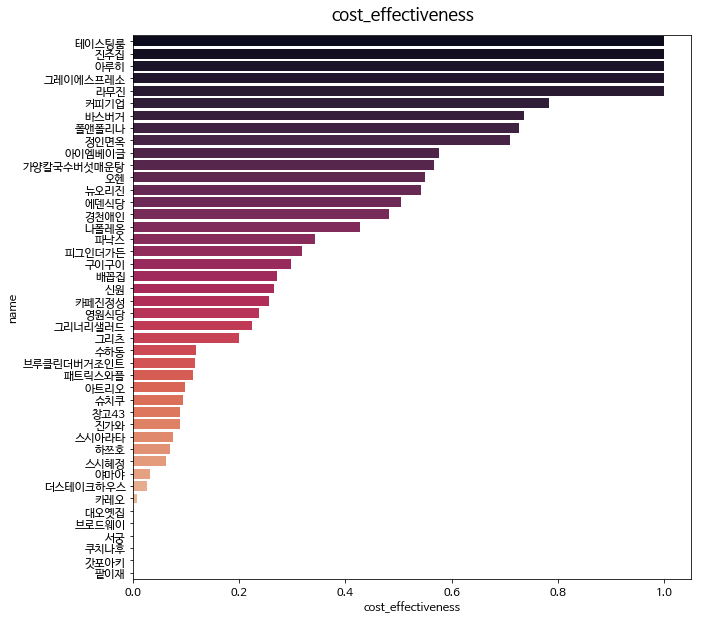

In [1461]:
temp_plot = feature_data.sort_values('cost_effectiveness', ascending=False)
fig = plt.figure(figsize=(10,10))
fig.suptitle('cost_effectiveness', size=17, y=0.92)
sns.barplot(temp_plot['cost_effectiveness'], temp_plot['name'], palette='rocket' )

---
## 4. 카페 리스트 따로 / 식당 리스트 따로

In [1470]:
cafe_data = feature_data[feature_data['New_category']=='카페']

In [1471]:
non_cafe_data = feature_data[feature_data['New_category']!='카페']

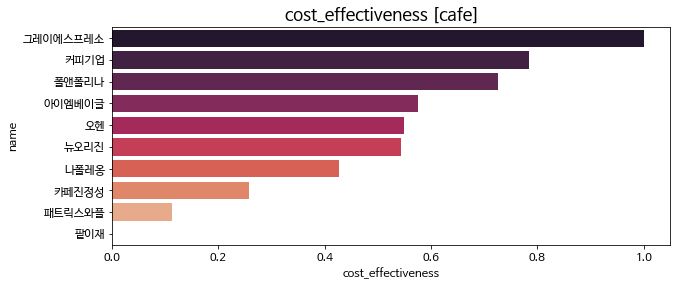

In [1487]:
temp_plot = cafe_data.sort_values('cost_effectiveness', ascending=False)
fig = plt.figure(figsize=(10,4))
fig.suptitle('cost_effectiveness [cafe]', size=17, y=0.95)
sns.barplot(temp_plot['cost_effectiveness'], temp_plot['name'], palette='rocket' )

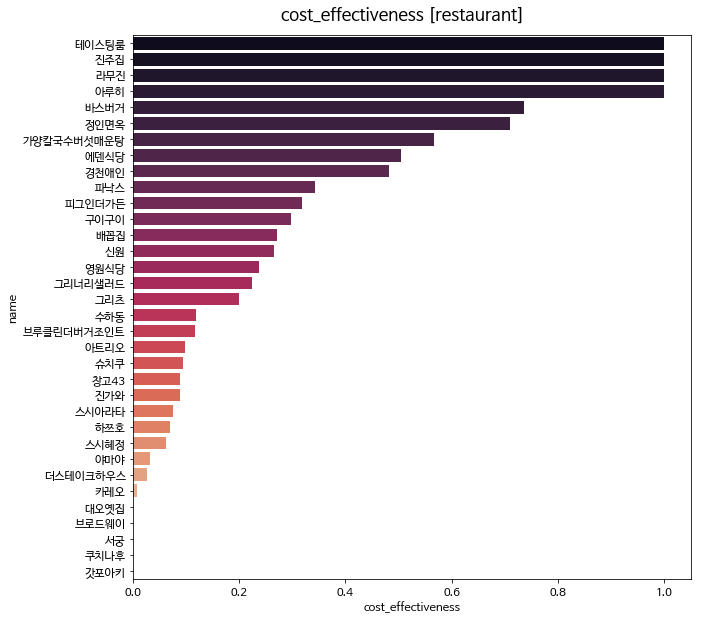

In [1476]:
temp_plot = non_cafe_data.sort_values('cost_effectiveness', ascending=False)
fig = plt.figure(figsize=(10,10))
fig.suptitle('cost_effectiveness [restaurant]', size=17, y=0.92)
sns.barplot(temp_plot['cost_effectiveness'], temp_plot['name'], palette='rocket' )

In [1479]:
feature_data[['name', 'prices_num', 'New_category', 'rank', 'dates_from_open',
       'price_grade', 'senti_score', 'mango_dinning_likes', '6M_score',
       '6M_num', 'review_score1', 'review_score1_scaled_wrt_cat', 'cost_effectiveness']].to_excel('../data/feature/가성비추가feature.xlsx', index=False)

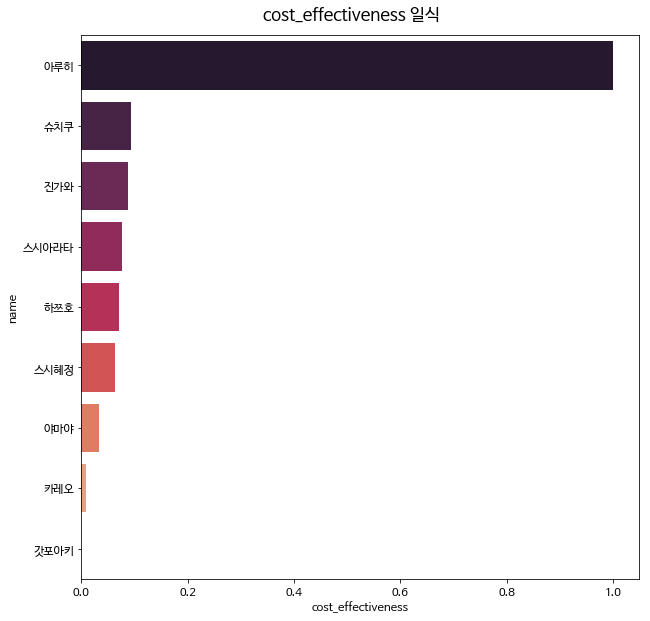

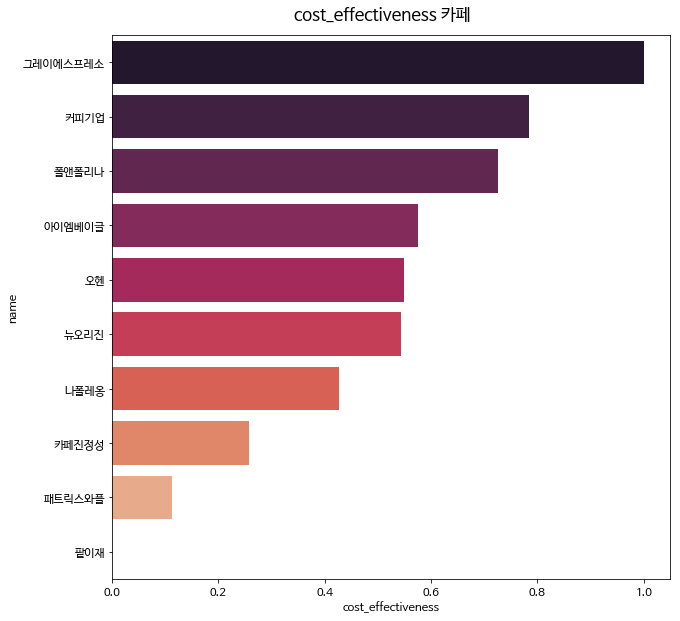

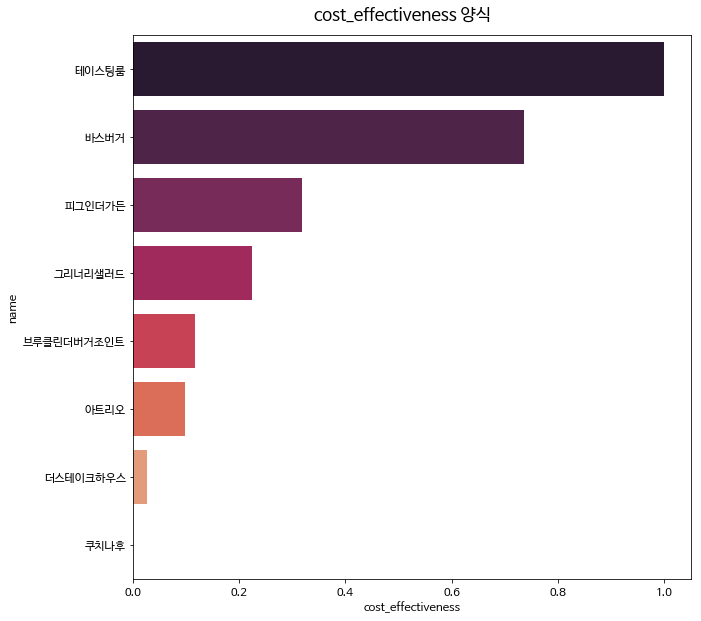

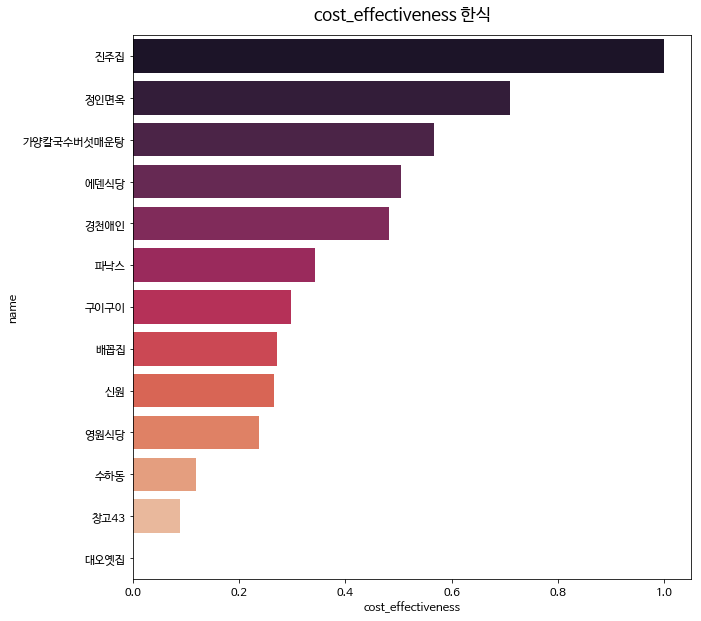

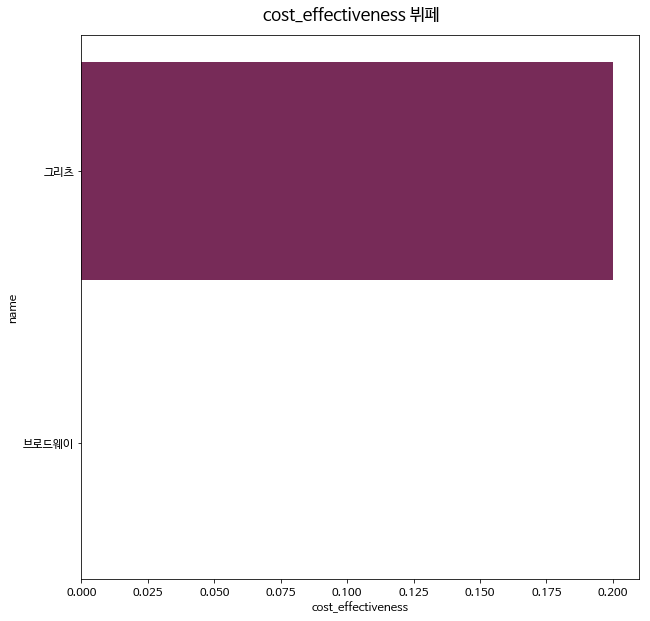

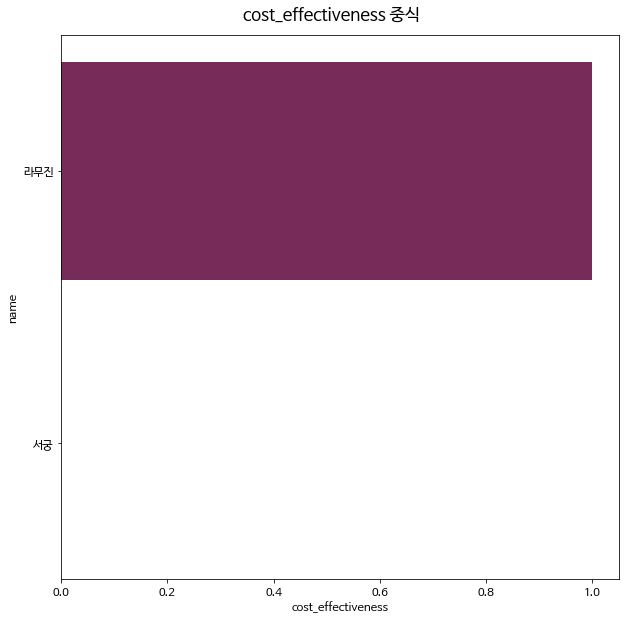

In [1484]:
for cat in feature_data.New_category.unique():
    temp_plot = feature_data[feature_data['New_category']==cat].sort_values('cost_effectiveness', ascending=False)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(f'cost_effectiveness {cat}', size=17, y=0.92)
    sns.barplot(temp_plot['cost_effectiveness'], temp_plot['name'], palette='rocket' )

---
## 증감율 구하기
1. step 설정 : 1개월, 2개월, 3개월
2. 1년 내 44개 지점의 step 별 리뷰수(사이트 총합) 테이블 작성
3. 1년 내 44개 지점의 step 별 리뷰점수(사이트 총합) 테이블 작성

4. 각 지점별 step 별 리뷰수 gradient 계산 

5. 각 지점별 step 별 리뷰점수 gradient 계산

6. 각 row별 증감률 총합 계산 ( 2년, 1년, 6개월, 3개월, 1개월)

7. 증감률 총합 일자 선택, sorting

8. sorting 후 top3~5에 대한 리뷰개수, 리뷰점수 -> barplot
---

In [1502]:
total_review = mango_review[['name', 'open_date', 'mango_dates']]

In [1506]:
total_review = pd.merge(total_review, google_review[['name','google_dates', 'google_scores']], how='outer', on='name')

In [1507]:
total_review = pd.merge(total_review, naver_review[['name','naver_dates', 'naver_scores']], how='outer', on='name')

In [1508]:
total_review = pd.merge(total_review, kakao_review[['name','kakao_dates', 'kakao_scores']], how='outer', on='name')

In [1509]:
total_review = pd.merge(total_review, dinning_review[['name','dinning_dates', 'dinning_scores']], how='outer', on='name')

In [2058]:
total_review.head()

,name,open_date,mango_dates,google_dates,google_scores,naver_dates,naver_scores,kakao_dates,kakao_scores,dinning_dates,dinning_scores,mango_scores
0,스시아라타,2020-03-02,"{0: '2020.06.08', 1: '2020.06.06', 2: '2020.04...","{0: '2달전', 1: '6달전', 2: '6달전', 3: '1년전', 4: '2...","{0: 5, 1: 5, 2: 5, 3: 5, 4: 4, 5: 5, 6: 5, 7: ...","{0: '2020.08.06', 1: '2020.07.30', 2: '2020.07...","{0: 5.0, 1: 4.5, 2: 5.0, 3: 5.0, 4: 5.0, 5: 5....","{0: '2020.08.27', 1: '2020.08.11', 2: '2020.06...","{0: '5', 1: '5', 2: '1', 3: '5', 4: '4', 5: '5...",{0: '2019년 4월 11일'},{0: 5},
1,오헨,2017-12-23,"{0: '2020.08.24', 1: '2020.07.26', 2: '2020.07...",{},{},"{0: '2020.08.24', 1: '2020.08.13', 2: '2020.07...","{0: 4.5, 1: 4.0, 2: 5.0, 3: 5.0, 4: 5.0, 5: 5....","{0: '2020.07.21', 1: '2020.02.28', 2: '2020.01...","{0: '3', 1: '3', 2: '4'}","{0: '2018년 9월 8일', 1: '2018년 2월 3일', 2: '6월 9일...","{0: 5, 1: 4, 2: 5, 3: 5}",
2,하쯔호,2014-01-22,"{0: '2020.06.03', 1: '2020.02.18', 2: '2019.10...","{0: '6달전', 1: '1년전', 2: '10달전', 3: '1년전', 4: '...","{0: 5, 1: 5, 2: 4, 3: 5, 4: 4, 5: 5, 6: 5, 7: ...","{0: '2020.08.28', 1: '2020.08.27', 2: '2020.08...","{0: 5.0, 1: 5.0, 2: 5.0, 3: 2.0, 4: 1.0, 5: 5....","{0: '2020.06.09', 1: '2020.04.21', 2: '2020.02...","{0: '5', 1: '4', 2: '5', 3: '4', 4: '5', 5: '5...",NaN,NaN,
3,피그인더가든,2019-11-22,"{0: '2020.08.07', 1: '2020.07.06', 2: '2020.05...","{0: '7달전', 1: '7달전', 2: '1년전', 3: '1년전', 4: '2...","{0: 4, 1: 2, 2: 4, 3: 4, 4: 4, 5: 5, 6: 5, 7: ...","{0: '2020.08.31', 1: '2020.08.30', 2: '2020.08...","{0: 4.0, 1: 2.5, 2: 4.5, 3: 3.5, 4: 5.0, 5: 4....","{0: '2020.08.30', 1: '2020.08.17', 2: '2020.08...","{0: '5', 1: '4', 2: '3', 3: '1', 4: '3', 5: '4...","{0: '2019년 11월 26일', 1: '3월 1일', 2: '5월 1일', 3...","{0: 5, 1: 5, 2: 3, 3: 4, 4: 4, 5: 4}",
4,정인면옥,2014-04-09,"{0: '21시간전', 1: '2020.07.26', 2: '2020.07.06',...","{0: '2달전', 1: '1년전', 2: '1년전', 3: '2년전', 4: '3...","{0: 3, 1: 4, 2: 4, 3: 2, 4: 1, 5: 4, 6: 5, 7: ...","{0: '2020.08.30', 1: '2020.08.29', 2: '2020.08...","{0: 0.5, 1: 5.0, 2: 2.0, 3: 4.5, 4: 4.0, 5: 5....","{0: '2020.08.19', 1: '2020.08.14', 2: '2020.08...","{0: '3', 1: '3', 2: '4', 3: '1', 4: '5', 5: '4...","{0: '7월 18일', 1: '5일 전', 2: '2019년 6월 29일', 3:...","{0: 5, 1: 5, 2: 3, 3: 5, 4: 4}",


In [1548]:
from datetime import timedelta
from datetime import datetime

In [1878]:
def read_str_to_dict(df, site):
    dates_dicts = {}
    scores_dicts = {}
    if site=='mango':
        df[f'{site}_scores'] = ''
    for i, (dates_dict_str, scores_dict_str) in enumerate(zip(df[f'{site}_dates'], df[f'{site}_scores'])):
        try:
            dates_dicts[i] = ast.literal_eval(dates_dict_str)
        except ValueError as e:
#             print(f'{i}, {e}, {site} in dates_dict_str literal_eval')
            if isinstance(dates_dict_str, str):
                dates_dict_str = dates_dict_str.replace('nan', '\'\'')
            elif np.isnan(dates_dict_str):
                dates_dict_str = '\'\''
#                 print(f'dates_dict_str is float nan. change to -> {dates_dict_str}')
            dates_dicts[i] = ast.literal_eval(dates_dict_str)
        except SyntaxError as e:
            dates_dict_str = dates_dict_str + '\'}'
#             print(f'{i}, {e}, {site} in dates_dict_str literal_eval')
            dates_dicts[i] = ast.literal_eval(dates_dict_str)
        if scores_dict_str:
            try:
                scores_dicts[i] = ast.literal_eval(scores_dict_str)
            except ValueError as e:
#                 print(f'{i}, {e}, {site} in scores_dict_str literal_eval')
                if isinstance(scores_dict_str, str):
                    scores_dict_str = scores_dict_str.replace('nan', '\'\'')
                elif np.isnan(scores_dict_str):
                    scores_dict_str = '\'\''
#                     print(f'scores_dict_str is float nan. change to -> {scores_dict_str}')
                scores_dicts[i] = ast.literal_eval(scores_dict_str)
            except SyntaxError as e:
                scores_dict_str = scores_dict_str + '\'}'
#                 print(f'{i}, {e}, {site} in scores_dict_str literal_eval')
                scores_dicts[i] = ast.literal_eval(scores_dict_str)
        else:
            scores_dicts[i] = {}
    return dates_dicts, scores_dicts

def set_value_wrt_time(df, delta_dict, rowidx, colname, time_bound, site='google'):
    selected_index = [idx for idx, delta in delta_dict.items() if delta >= time_bound]
    if site != 'mango':
        for col in [colname+'_num', colname+'_score']:
            if not col in df.columns:
                df[col] = ''
    try:
        df.loc[rowidx, colname+'_num'] = len(selected_index)
        if site != 'mango':
            df.loc[rowidx, colname+'_score'] = np.mean([float(scores_dict[x]) for x in selected_index])
    except Exception as e:
        print(scores_dict)
        print(selected_index)
        raise(e)
        print(f'{rowidx}, {e}, {colname} in set_value_wrt_time')
                
def preprocess_datetime2(df:pd.DataFrame):    
    date_dicts = {}
    score_dicts = {}
    timedeltas = {}
    score_results = {}
    timedeltas['name'] = {}
    score_results['name'] = {}
    for site in ['google', 'naver', 'kakao', 'mango', 'dinning']:
#         print(f'{site} preprocess start')
        date_dicts[site], score_dicts[site] = read_str_to_dict(df, site)
        timedeltas[site] = {}
        score_results[site] = {}
        
    date_df = pd.DataFrame(date_dicts)
    date_df['max_length'] = 0
    date_df['max_site'] = 0
    for i, row in date_df.iterrows():
        max_length = 0
        max_site = 'google'
        for col in xsdf.columns:
            if isinstance(row[col], dict) and len(row[col]) > max_length:
                max_length = len(row[col])
                max_site = col
        date_df.loc[i, 'max_length'] = max_length
        date_df.loc[i, 'max_site'] = max_site
    score_df = pd.DataFrame(score_dicts)
    
    basis_titme = datetime.strptime('2020.09.01', '%Y.%m.%d')

    for i, row in date_df.iterrows():
        row_idx = date_df['max_length'][:i].sum()
        print(f"{i} row start, this_count : {row['max_length']}, cur_row : {row_idx}")
        place_name = df.loc[i, 'name']
        for idx in range(date_df.loc[i, 'max_length']):
            for site in ['google', 'naver', 'kakao', 'mango', 'dinning']:
                cur_idx = row_idx + idx
                timedeltas['name'][cur_idx] = place_name
                score_results['name'][cur_idx] = place_name
                try:
                    date_str = date_df.loc[i, site][idx]
                    if site != 'mango':
                        score = score_df.loc[i, site][idx]
                    else:
                        score = np.nan
                except Exception as e:
#                     print(f'exception {e} {site} {cur_idx}')
                    timedeltas[site][cur_idx] = np.nan
                    score_results[site][cur_idx] = np.nan
                    continue

                if '전' in date_str:
                    if '시간' in date_str:
                        timedeltas[site][cur_idx] = 0
                    elif '일' in date_str:
                        timedeltas[site][cur_idx] = int(date_str.split('일')[0])
                    elif '달' in date_str:
                        timedeltas[site][cur_idx] = 30 * int(date_str.split('달')[0])
                    elif '년' in date_str:
                        timedeltas[site][cur_idx] = 365 * int(date_str.split('년')[0])

                elif '일' in date_str:
                    if not '년' in date_str:
                        date_str = '2020년 ' + date_str
                    try:
                        timedeltas[site][cur_idx] = (basis_titme - datetime.strptime(date_str, '%Y년 %m월 %d일')).days
                    except Exception as e:
#                         print(f'{i}, {e}, {site} [date_str] in "%Y년 %m월 %d일" strptime')
                        timedeltas[site][cur_idx] = np.nan
                        pass
                else:
                    try:
                        timedeltas[site][cur_idx] = (basis_titme - datetime.strptime(date_str, '%Y.%m.%d')).days
                    except Exception as e:
#                         print(f'{i}, {e}, {site}, [date_str] in "%Y.%m.%d" strptime')
                        timedeltas[site][cur_idx] = np.nan

                score_results[site][cur_idx] = score

    return timedeltas, score_results

In [1879]:
timedeltas, score_results = preprocess_datetime2(total_review)

0 row start, this_count : 77, cur_row : 0
1 row start, this_count : 78, cur_row : 77
2 row start, this_count : 91, cur_row : 155
3 row start, this_count : 299, cur_row : 246
4 row start, this_count : 968, cur_row : 545
5 row start, this_count : 334, cur_row : 1513
6 row start, this_count : 759, cur_row : 1847
7 row start, this_count : 968, cur_row : 2606
8 row start, this_count : 95, cur_row : 3574
9 row start, this_count : 965, cur_row : 3669
10 row start, this_count : 191, cur_row : 4634
11 row start, this_count : 109, cur_row : 4825
12 row start, this_count : 165, cur_row : 4934
13 row start, this_count : 111, cur_row : 5099
14 row start, this_count : 28, cur_row : 5210
15 row start, this_count : 81, cur_row : 5238
16 row start, this_count : 247, cur_row : 5319
17 row start, this_count : 21, cur_row : 5566
18 row start, this_count : 30, cur_row : 5587
19 row start, this_count : 68, cur_row : 5617
20 row start, this_count : 1269, cur_row : 5685
21 row start, this_count : 329, cur_row

In [1978]:
cur_time = 365
step = 365/12
name_df = pd.merge(mango_review[['rank','name']],  pd.DataFrame(review_time['name'].value_counts(sort=False)).reset_index().rename(columns={'name':'count','index':'name'}), on='name')
review_count_time = pd.DataFrame()
review_score_time = pd.DataFrame()

# 탈출 조건 : 2020년 9월 1일까지 검색한다.
while cur_time > -1:
    start = str(datetime(2020,9,1) - timedelta(days=+cur_time+step)).split(' ')[0].replace('-','.')
    end = str(datetime(2020,9,1) - timedelta(days=+cur_time)).split(' ')[0].replace('-','.')
    colname = f'{start}~{end}'
    # 개월 사이의 mask를 구한다.
    mask = (review_time.iloc[:, 1:] >= cur_time) & (review_time.iloc[:, 1:] < cur_time + step)
    # 구한 mask로 각 지점별로 mask를 덧 씌우고, 각 개월별 count, mean_score를 구한다.
    for idx, row in name_df.iterrows():
        if cur_time == 365:
            review_count_time.loc[idx, 'name'] = row['name']
            review_score_time.loc[idx, 'name'] = row['name']
        try:
            pre = name_df['count'][:idx].sum()
            post = name_df['count'][:idx+1].sum()
            review_count_time.loc[idx, colname] = np.sum(mask.iloc[pre:post, :]).sum()
            review_score_time.loc[idx, colname] = review_score.iloc[pre:post, 1:].where(mask).mean().mean()
        except TypeError:
            print(f'cur_time : {cur_time}, idx : {idx}, name : {row["name"]}, row : {row}')
            raise
    # 다음 step 시간으로 이동한다.
    cur_time -= step

In [2023]:
review_score_time.to_excel('../data/리뷰증감/review_score_time.xlsx', index=False)
review_count_time.to_excel('../data/리뷰증감/review_count_time.xlsx', index=False)

## score 결측치 대체 (이전달 점수로 대체)

In [1988]:
review_score_time_copy = review_score_time.copy()

In [1989]:
review_score_time_copy.iloc[:, 1:] = review_score_time.iloc[:,1:].fillna(method = 'ffill', axis=1).fillna(method = 'bfill', axis=1)

## score gradient 계산

### 결측치 대체 전

In [2030]:
review_score_time_grad_before = review_score_time.iloc[:, 1:].diff(axis=1).iloc[:, 1:]

In [2031]:
review_score_time_grad_before['name'] = review_score_time_copy['name']

In [2032]:
review_score_time_grad_before = review_score_time_grad_before[['name']+list(review_score_time_grad_before.columns[:-1])]
review_score_time_grad_before.head()

,name,2019.09.02~2019.10.02,2019.10.02~2019.11.01,2019.11.01~2019.12.02,2019.12.02~2020.01.01,2020.01.01~2020.02.01,2020.02.01~2020.03.02,2020.03.02~2020.04.01,2020.04.01~2020.05.02,2020.05.02~2020.06.01,2020.06.01~2020.07.02,2020.07.02~2020.08.01,2020.08.01~2020.09.01
0,스시아라타,NaN,NaN,-0.125000,-1.250000,1.714286,0.119048,0.166667,-0.250000,-0.750000,1.000000,-0.464286,0.464286
1,오헨,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,-1.000000,NaN,NaN,0.187500,-0.750000
2,하쯔호,NaN,NaN,0.035714,0.214286,0.000000,0.000000,-0.125000,0.125000,-0.500000,0.250000,0.125000,-0.437500
3,피그인더가든,0.072222,0.545455,0.136364,-0.619318,0.312500,0.224715,-0.226988,-0.528283,0.388889,0.109524,-0.043838,-0.141457
4,정인면옥,1.101911,-0.655172,0.246082,-0.313131,-0.383041,0.033835,0.529762,-0.286765,-0.458606,0.249537,0.382328,-0.025692


In [2114]:
score_temp.to_excel('../data/리뷰증감률/review_score_time_grad_before.xlsx', index=False)

In [2065]:
score_temp = pd.merge(feature_data[['name', 'New_category']], review_score_time_grad_before, on='name').reset_index(drop=True)

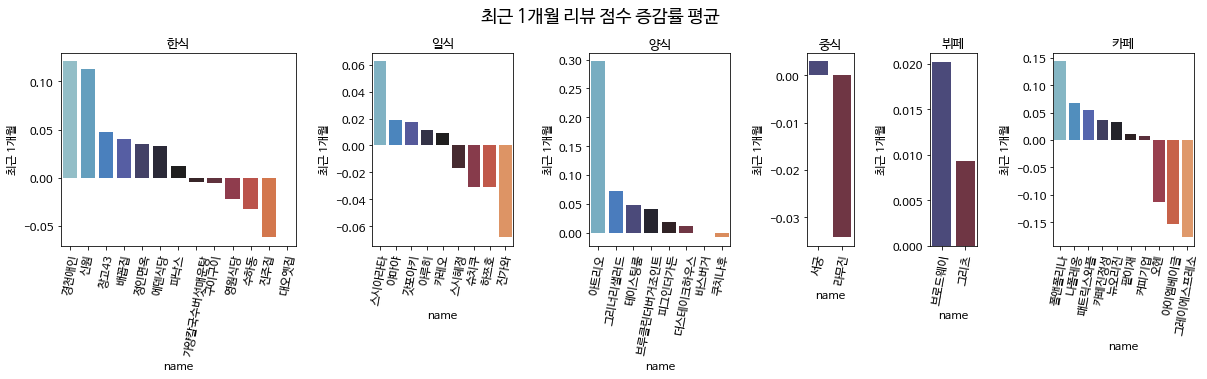

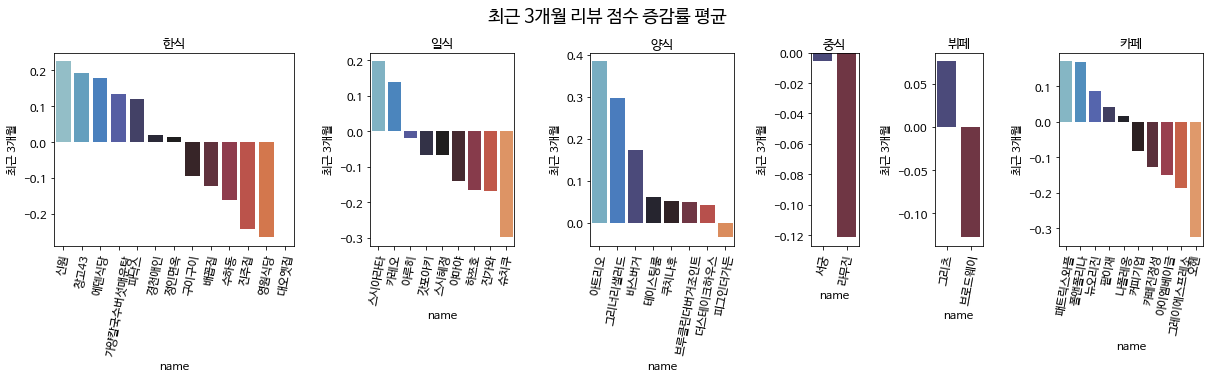

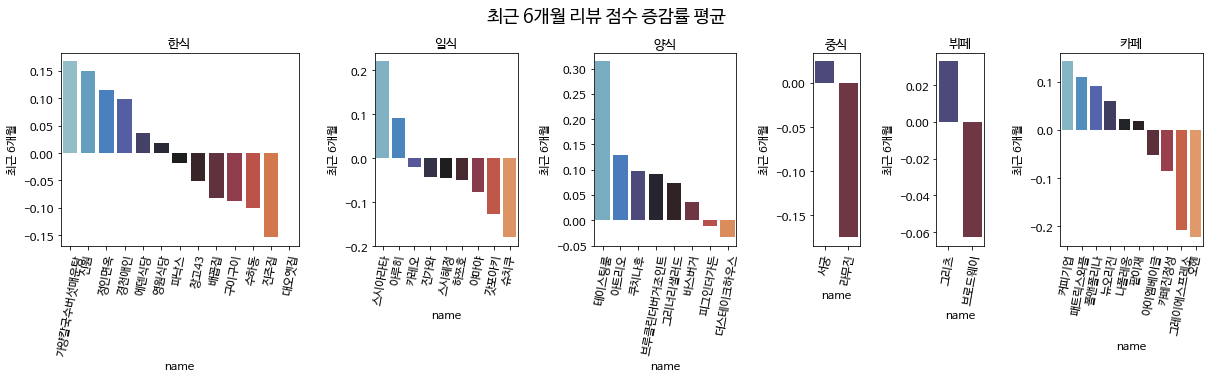

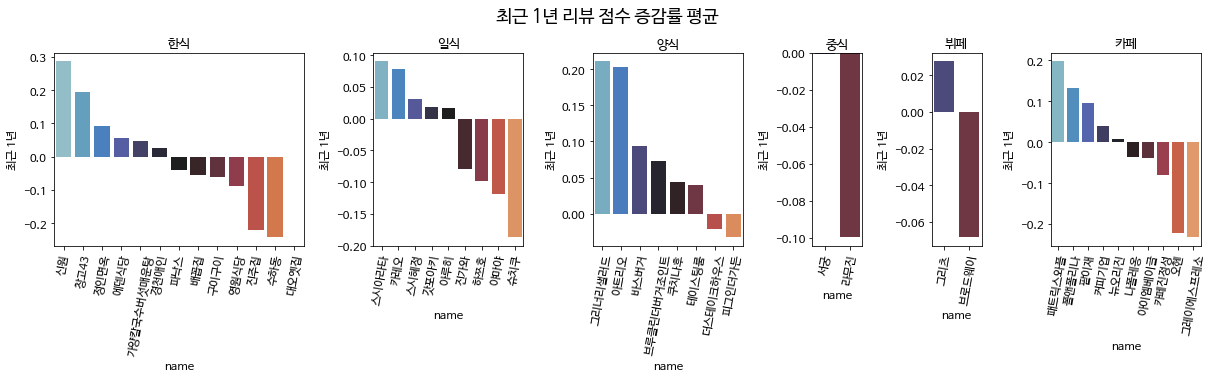

In [2109]:
score_temp = pd.merge(feature_data[['name', 'New_category']], review_score_time_grad_before, on='name').reset_index(drop=True)

def change_width(ax, new_value) :
#     locs = ax.get_xticks()
    for i,patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
#         patch.set_x(locs[i//4] - (new_value * .5))
        
for period in ['최근 1개월', '최근 3개월', '최근 6개월', '최근 1년']:
    cols = score_temp.shape[1]
    if '1개월' in period:
        score_temp[period] = score_temp.iloc[:,cols-1:cols].mean(axis=1)
    elif '3개월' in period:
        score_temp[period] = score_temp.iloc[:,cols-3:cols].mean(axis=1)
    elif '6개월' in period:
        score_temp[period] = score_temp.iloc[:,cols-6:cols].mean(axis=1)
    else:
        score_temp[period] = score_temp.iloc[:,cols-6:cols].mean(axis=1)
    score_temp = score_temp.sort_values(['New_category', period], ascending=False).reset_index(drop=True)
#     fig, ax = plt.subplots(1,10)
    fig, ax = plt.subplots(1, 6, 
                       gridspec_kw={
                           'width_ratios': [5,3,3,1,1,3]})
    fig.set_size_inches(17,5)
#     ax = plt.subplot2grid((2, 2), (0, 0))
    for i, cat in enumerate(['한식', '일식', '양식', '중식', '뷔페', '카페']):
        fig.suptitle(f'{period} 리뷰 점수 증감률 평균', size=18, y=1.05)
        sns.barplot('name', period, data=score_temp[score_temp['New_category']==cat], palette='icefire', ax=ax[i])
        ax[i].set_title(f'{cat}', size=13)
    #     ax = sns.barplot('New_category', period, hue='name', data=score_temp, palette='icefire')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=80)
    fig.tight_layout()
    plt.savefig(f'../data/리뷰증감률/{period} 리뷰 점수 증감률 평균.png', dpi=300)

<!-- ### 결측치 대체 후 -->

In [1994]:
review_score_time_grad = review_score_time_copy.iloc[:, 1:].diff(axis=1).iloc[:, 1:]

In [1996]:
review_score_time_grad['name'] = review_score_time_copy['name']

In [2000]:
review_score_time_grad = review_score_time_grad[['name']+list(review_score_time_grad.columns[:-1])]
review_score_time_grad.head()

,name,2019.09.02~2019.10.02,2019.10.02~2019.11.01,2019.11.01~2019.12.02,2019.12.02~2020.01.01,2020.01.01~2020.02.01,2020.02.01~2020.03.02,2020.03.02~2020.04.01,2020.04.01~2020.05.02,2020.05.02~2020.06.01,2020.06.01~2020.07.02,2020.07.02~2020.08.01,2020.08.01~2020.09.01
0,스시아라타,0.000000,-0.319444,-0.125000,-1.250000,1.714286,0.119048,0.166667,-0.250000,-0.750000,1.000000,-0.464286,0.464286
1,오헨,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.812500,0.187500,-0.750000
2,하쯔호,0.000000,0.074324,0.035714,0.214286,0.000000,0.000000,-0.125000,0.125000,-0.500000,0.250000,0.125000,-0.437500
3,피그인더가든,0.072222,0.545455,0.136364,-0.619318,0.312500,0.224715,-0.226988,-0.528283,0.388889,0.109524,-0.043838,-0.141457
4,정인면옥,1.101911,-0.655172,0.246082,-0.313131,-0.383041,0.033835,0.529762,-0.286765,-0.458606,0.249537,0.382328,-0.025692


In [2022]:
review_score_time_grad.to_excel('../data/리뷰증감률/review_score_time_grad.xlsx', index=False)

## review count gradient 계산

In [2016]:
review_count_time_grad =review_count_time.copy()

In [2017]:
review_count_time_grad.iloc[:, 2:] = review_count_time_grad.iloc[:, 1:].diff(axis=1).iloc[:, 1:]

In [2018]:
review_count_time_grad = review_count_time_grad.drop('2019.08.02~2019.09.02', axis=1)

In [2020]:
review_count_time_grad.head()

,name,2019.09.02~2019.10.02,2019.10.02~2019.11.01,2019.11.01~2019.12.02,2019.12.02~2020.01.01,2020.01.01~2020.02.01,2020.02.01~2020.03.02,2020.03.02~2020.04.01,2020.04.01~2020.05.02,2020.05.02~2020.06.01,2020.06.01~2020.07.02,2020.07.02~2020.08.01,2020.08.01~2020.09.01
0,스시아라타,-37.0,10.0,-5.0,1.0,2.0,0.0,-3.0,2.0,-3.0,2.0,2.0,-5.0
1,오헨,0.0,0.0,1.0,3.0,4.0,-3.0,1.0,-5.0,0.0,6.0,-3.0,-1.0
2,하쯔호,-34.0,2.0,4.0,-6.0,-1.0,2.0,1.0,0.0,-2.0,2.0,0.0,7.0
3,피그인더가든,-124.0,12.0,-3.0,13.0,-10.0,6.0,0.0,9.0,-12.0,22.0,7.0,5.0
4,정인면옥,-315.0,25.0,-6.0,-1.0,-5.0,-6.0,23.0,-7.0,2.0,15.0,8.0,17.0


In [2115]:
count_temp.to_excel('../data/리뷰증감률/review_count_time_grad.xlsx', index=False)

In [2110]:
count_temp = pd.merge(feature_data[['name', 'New_category']], review_count_time_grad, on='name').reset_index(drop=True)

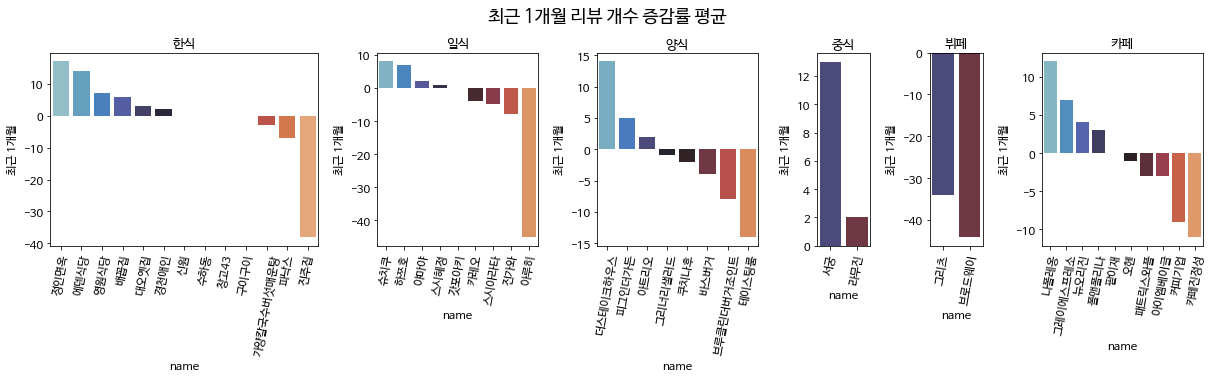

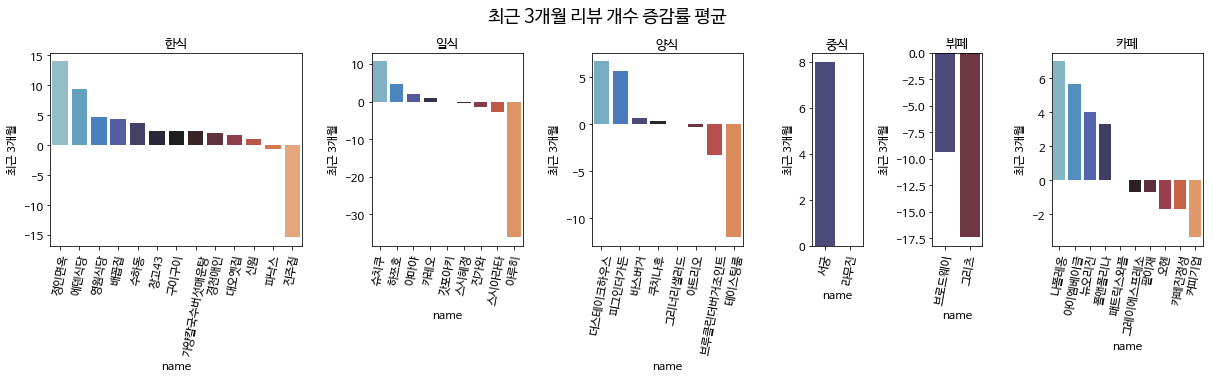

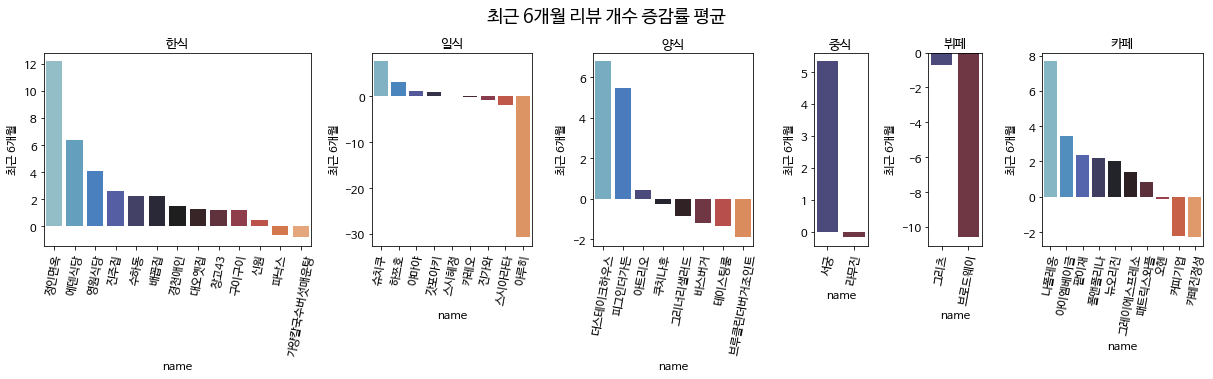

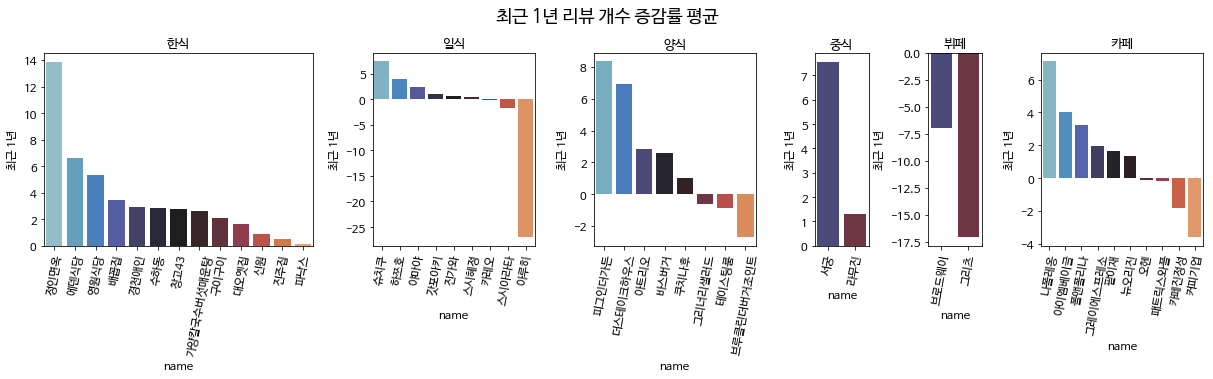

In [2112]:
for period in ['최근 1개월', '최근 3개월', '최근 6개월', '최근 1년']:
    cols = count_temp.shape[1]
    if '1개월' in period:
        count_temp[period] = count_temp.iloc[:,cols-1:cols].mean(axis=1)
    elif '3개월' in period:
        count_temp[period] = count_temp.iloc[:,cols-3:cols].mean(axis=1)
    elif '6개월' in period:
        count_temp[period] = count_temp.iloc[:,cols-6:cols].mean(axis=1)
    else:
        count_temp[period] = count_temp.iloc[:,cols-6:cols].mean(axis=1)
    count_temp = count_temp.sort_values(['New_category', period], ascending=False).reset_index(drop=True)
#     fig, ax = plt.subplots(1,10)
    fig, ax = plt.subplots(1, 6, 
                       gridspec_kw={
                           'width_ratios': [5,3,3,1,1,3]})
    fig.set_size_inches(17,5)
#     ax = plt.subplot2grid((2, 2), (0, 0))
    for i, cat in enumerate(['한식', '일식', '양식', '중식', '뷔페', '카페']):
        fig.suptitle(f'{period} 리뷰 개수 증감률 평균', size=18, y=1.05)
        sns.barplot('name', period, data=count_temp[count_temp['New_category']==cat], palette='icefire', ax=ax[i])
        ax[i].set_title(f'{cat}', size=13)
    #     ax = sns.barplot('New_category', period, hue='name', data=score_temp, palette='icefire')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=80)
    fig.tight_layout()
    plt.savefig(f'../data/리뷰증감률/{period} 리뷰 개수 증감률 평균.png', dpi=300)